In [1]:
# Custom dataset
from PIL import Image
import torch.utils.data as data
import os
import random


class DatasetFromFolder(data.Dataset):
    def __init__(self, path2img, direction='AtoB', transform=False): #b2a : binary to ascii
        super().__init__()
        self.direction = direction
        self.path2a = 'C:/Users/Mobile/Desktop/woo/pix2pix-master/pix2pix-master/data/sample_pattern'
        self.path2b = 'C:/Users/Mobile/Desktop/woo/pix2pix-master/pix2pix-master/data/sample_convert'
        self.img_filenames = [x for x in listdir(self.path2a)]
        self.transform = transform

    def __getitem__(self, index):
        a = Image.open(join(self.path2a, self.img_filenames[index])).convert('RGB')
        b = Image.open(join(self.path2b, self.img_filenames[index])).convert('RGB')
        
        if self.transform:
            a = self.transform(a)
            b = self.transform(b)

        if self.direction == 'AtoB':
            return a,b
        else:
            return b,a

    def __len__(self):
        return len(self.img_filenames)

In [2]:
# Code referenced from https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
import tensorflow as tf
import numpy as np
# import scipy.misc
import matplotlib.pyplot as plt

try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO  # Python 3.x


class Logger(object):
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            # scipy.misc.toimage(img).save(s, format="png")
            plt.imsave(s, img, format='png')

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)

    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values ** 2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()

In [3]:
import torch


class ConvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, activation=True, batch_norm=True):
        super(ConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding)
        self.activation = activation
        self.lrelu = torch.nn.LeakyReLU(0.2, True)
        self.batch_norm = batch_norm
        self.bn = torch.nn.BatchNorm2d(output_size)

    def forward(self, x):
        if self.activation:
            out = self.conv(self.lrelu(x))
        else:
            out = self.conv(x)

        if self.batch_norm:
            return self.bn(out)
        else:
            return out


class DeconvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, batch_norm=True, dropout=False):
        super(DeconvBlock, self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size, output_size, kernel_size, stride, padding)
        self.bn = torch.nn.BatchNorm2d(output_size)
        self.drop = torch.nn.Dropout(0.5)
        self.relu = torch.nn.ReLU(True)
        self.batch_norm = batch_norm
        self.dropout = dropout

    def forward(self, x):
        if self.batch_norm:
            out = self.bn(self.deconv(self.relu(x)))
        else:
            out = self.deconv(self.relu(x))

        if self.dropout:
            return self.drop(out)
        else:
            return out


class Generator(torch.nn.Module):
    def __init__(self, input_dim, num_filter, output_dim):
        super(Generator, self).__init__()

        # Encoder
        self.conv1 = ConvBlock(input_dim, num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(num_filter, num_filter * 2)
        self.conv3 = ConvBlock(num_filter * 2, num_filter * 4)
        self.conv4 = ConvBlock(num_filter * 4, num_filter * 8)
        self.conv5 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv6 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv7 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv8 = ConvBlock(num_filter * 8, num_filter * 8, batch_norm=False)
        # Decoder
        self.deconv1 = DeconvBlock(num_filter * 8, num_filter * 8, dropout=True)
        self.deconv2 = DeconvBlock(num_filter * 8 * 2, num_filter * 8, dropout=True)
        self.deconv3 = DeconvBlock(num_filter * 8 * 2, num_filter * 8, dropout=True)
        self.deconv4 = DeconvBlock(num_filter * 8 * 2, num_filter * 8)
        self.deconv5 = DeconvBlock(num_filter * 8 * 2, num_filter * 4)
        self.deconv6 = DeconvBlock(num_filter * 4 * 2, num_filter * 2)
        self.deconv7 = DeconvBlock(num_filter * 2 * 2, num_filter)
        self.deconv8 = DeconvBlock(num_filter * 2, output_dim, batch_norm=False)

    def forward(self, x):
        # Encoder
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)
        enc6 = self.conv6(enc5)
        enc7 = self.conv7(enc6)
        enc8 = self.conv8(enc7)
        # Decoder with skip-connections
        dec1 = self.deconv1(enc8)
        dec1 = torch.cat([dec1, enc7], 1)
        dec2 = self.deconv2(dec1)
        dec2 = torch.cat([dec2, enc6], 1)
        dec3 = self.deconv3(dec2)
        dec3 = torch.cat([dec3, enc5], 1)
        dec4 = self.deconv4(dec3)
        dec4 = torch.cat([dec4, enc4], 1)
        dec5 = self.deconv5(dec4)
        dec5 = torch.cat([dec5, enc3], 1)
        dec6 = self.deconv6(dec5)
        dec6 = torch.cat([dec6, enc2], 1)
        dec7 = self.deconv7(dec6)
        dec7 = torch.cat([dec7, enc1], 1)
        dec8 = self.deconv8(dec7)
        out = torch.nn.Tanh()(dec8)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)
            if isinstance(m, DeconvBlock):
                torch.nn.init.normal(m.deconv.weight, mean, std)


class Generator128(torch.nn.Module):
    def __init__(self, input_dim, num_filter, output_dim):
        super(Generator128, self).__init__()

        # Encoder
        self.conv1 = ConvBlock(input_dim, num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(num_filter, num_filter * 2)
        self.conv3 = ConvBlock(num_filter * 2, num_filter * 4)
        self.conv4 = ConvBlock(num_filter * 4, num_filter * 8)
        self.conv5 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv6 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv7 = ConvBlock(num_filter * 8, num_filter * 8, batch_norm=False)
        # Decoder
        self.deconv1 = DeconvBlock(num_filter * 8, num_filter * 8, dropout=True)
        self.deconv2 = DeconvBlock(num_filter * 8 * 2, num_filter * 8, dropout=True)
        self.deconv3 = DeconvBlock(num_filter * 8 * 2, num_filter * 8, dropout=True)
        self.deconv4 = DeconvBlock(num_filter * 8 * 2, num_filter * 4)
        self.deconv5 = DeconvBlock(num_filter * 4 * 2, num_filter * 2)
        self.deconv6 = DeconvBlock(num_filter * 2 * 2, num_filter)
        self.deconv7 = DeconvBlock(num_filter * 2, output_dim, batch_norm=False)

    def forward(self, x):
        # Encoder
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)
        enc6 = self.conv6(enc5)
        enc7 = self.conv7(enc6)
        # Decoder with skip-connections
        dec1 = self.deconv1(enc7)
        dec1 = torch.cat([dec1, enc6], 1)
        dec2 = self.deconv2(dec1)
        dec2 = torch.cat([dec2, enc5], 1)
        dec3 = self.deconv3(dec2)
        dec3 = torch.cat([dec3, enc4], 1)
        dec4 = self.deconv4(dec3)
        dec4 = torch.cat([dec4, enc3], 1)
        dec5 = self.deconv5(dec4)
        dec5 = torch.cat([dec5, enc2], 1)
        dec6 = self.deconv6(dec5)
        dec6 = torch.cat([dec6, enc1], 1)
        dec7 = self.deconv7(dec6)
        out = torch.nn.Tanh()(dec7)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)
            if isinstance(m, DeconvBlock):
                torch.nn.init.normal(m.deconv.weight, mean, std)


class Discriminator(torch.nn.Module):
    def __init__(self, input_dim, num_filter, output_dim):
        super(Discriminator, self).__init__()

        self.conv1 = ConvBlock(input_dim, num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(num_filter, num_filter * 2)
        self.conv3 = ConvBlock(num_filter * 2, num_filter * 4)
        self.conv4 = ConvBlock(num_filter * 4, num_filter * 8, stride=1)
        self.conv5 = ConvBlock(num_filter * 8, output_dim, stride=1, batch_norm=False)

    def forward(self, x, label):
        x = torch.cat([x, label], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        out = torch.nn.Sigmoid()(x)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)


class Discriminator128(torch.nn.Module):
    def __init__(self, input_dim, num_filter, output_dim):
        super(Discriminator128, self).__init__()

        self.conv1 = ConvBlock(input_dim, num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(num_filter, num_filter * 2)
        self.conv3 = ConvBlock(num_filter * 2, num_filter * 4, stride=1)
        self.conv4 = ConvBlock(num_filter * 4, output_dim, stride=1, batch_norm=False)

    def forward(self, x, label):
        x = torch.cat([x, label], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        out = torch.nn.Sigmoid()(x)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)

In [4]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import os



# For logger
def to_np(x):
    return x.data.cpu().numpy()


def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)


# De-normalization
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)


# Plot losses
def plot_loss(d_losses, g_losses, num_epochs, save=False, save_dir='results/', show=False):
    fig, ax = plt.subplots()
    ax.set_xlim(0, num_epochs)
    ax.set_ylim(0, max(np.max(g_losses), np.max(d_losses))*1.1)
    plt.xlabel('# of Epochs')
    plt.ylabel('Loss values')
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.legend()

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'Loss_values_epoch_{:d}'.format(num_epochs) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()


def plot_test_result(input, target, gen_image, epoch, training=True, save=False, save_dir='results/', show=False, fig_size=(5, 5)):
    if not training:
        fig_size = (input.size(2) * 3 / 100, input.size(3)/100)

    fig, axes = plt.subplots(1, 3, figsize=fig_size)
    imgs = [input, gen_image, target]
    for ax, img in zip(axes.flatten(), imgs):
        ax.axis('off')
        ax.set_adjustable('box-forced')
        # Scale to 0-255
        img = (((img[0] - img[0].min()) * 255) / (img[0].max() - img[0].min())).numpy().transpose(1, 2, 0).astype(np.uint8)
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)

    if training:
        title = 'Epoch {0}'.format(epoch + 1)
        fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        if training:
            save_fn = save_dir + 'Result_epoch_{:d}'.format(epoch+1) + '.png'
        else:
            save_fn = save_dir + 'Test_result_{:d}'.format(epoch+1) + '.png'
            fig.subplots_adjust(bottom=0)
            fig.subplots_adjust(top=1)
            fig.subplots_adjust(right=1)
            fig.subplots_adjust(left=0)
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()


# Make gif
def make_gif(dataset, num_epochs, save_dir='results/'):
    gen_image_plots = []
    for epoch in range(num_epochs):
        # plot for generating gif
        save_fn = save_dir + 'Result_epoch_{:d}'.format(epoch + 1) + '.png'
        gen_image_plots.append(imageio.imread(save_fn))

    imageio.mimsave(save_dir + dataset + '_pix2pix_epochs_{:d}'.format(num_epochs) + '.gif', gen_image_plots, fps=5)


In [5]:
print(os.getcwd())
import torch, gc
gc.collect()
torch.cuda.empty_cache()

C:\Users\Mobile\Desktop\woo\pix2pix-master\pix2pix-master


In [5]:
def generate_image(G, x_, y_):
    G.eval()
    test_images = G(x_.squeeze(0))

    size_figure_grid = 3
    fig, ax = plt.subplots(1, size_figure_grid, figsize=(10, 4))
    for j in range(size_figure_grid):
        ax[j].get_xaxis().set_visible(False)
        ax[j].get_yaxis().set_visible(False)

    ax[0].cla()
    ax[0].imshow((x_.cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)
    ax[1].cla()
    ax[1].imshow((test_images[0].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)
    ax[2].cla()
    ax[2].imshow((y_.cpu().numpy().transpose(1, 2, 0) + 1) / 2)

    plt.show()

2846
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


C:\Users\Mobile\anaconda3\envs\V2F\lib\site-packages\torchvision\transforms\transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


(-0.5, 255.5, 255.5, -0.5)

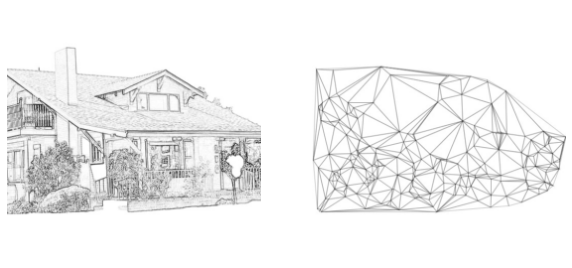

In [6]:
from PIL import ImageFile
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from os import listdir
from os.path import join
# Data pre-processing
transform = transforms.Compose([transforms.Scale(256),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                transforms.Resize((256,256))])

# Train data
data_dir ='./data/'
test_dir='./test/'
train_data = DatasetFromFolder(data_dir, direction="BtoA", transform=transform
                               )
train_data_loader = torch.utils.data.DataLoader(dataset=train_data,
                                                batch_size=32,
                                                shuffle=True)


test_data=DatasetFromFolder(test_dir, direction="BtoA",transform=transform)


print(len(train_data))
a,b = train_data[0]
print(train_data[0][0])
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(a*0.5 + 0.5)) #tensor 데이터를 pil데이터로 변환

plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5*b+0.5))
plt.axis('off')


In [8]:
from os import listdir
from os.path import join
import torch
from torchvision import transforms
from torch.autograd import Variable
import argparse
import os

# Directories for loading data and saving results
data_dir ='./data/'
save_dir = 'results/'
model_dir = 'model/'

if not os.path.exists(save_dir):
    os.mkdir(save_dir)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

# Data pre-processing
transform = transforms.Compose([transforms.Scale(256),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                transforms.Resize((256,256))])

# Train data
train_data = DatasetFromFolder(data_dir, direction="BtoA", transform=transform
                               )
train_data_loader = torch.utils.data.DataLoader(dataset=train_data,
                                                batch_size=32,
                                                shuffle=True)



test_data_loader = torch.utils.data.DataLoader(dataset=test_data,
                                               batch_size=2,
                                               shuffle=False)
test_input, test_target = test_data_loader.__iter__().__next__()
# Models
G = Generator(3, 64, 3)
D = Discriminator(6, 64, 1)
G.cuda()
D.cuda()
G.normal_weight_init(mean=0.0, std=0.02)
D.normal_weight_init(mean=0.0, std=0.02)



# Loss function
BCE_loss = torch.nn.BCELoss().cuda()
L1_loss = torch.nn.L1Loss().cuda()

# Optimizers
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training GAN
D_avg_losses = []
G_avg_losses = []

step = 0
for epoch in range(100):
    D_losses = []
    G_losses = []

    # training
    for input, target in train_data_loader:

        # input & target image data
        x_ = Variable(input.cuda())
        y_ = Variable(target.cuda())

        # Train discriminator with real data
        D_real_decision = D(x_, y_).squeeze()
        real_ = Variable(torch.ones(D_real_decision.size()).cuda())
        D_real_loss = BCE_loss(D_real_decision, real_)

        # Train discriminator with fake data
        gen_image = G(x_)
        D_fake_decision = D(x_, gen_image).squeeze()
        fake_ = Variable(torch.zeros(D_fake_decision.size()).cuda())
        D_fake_loss = BCE_loss(D_fake_decision, fake_)

        # Back propagation
        D_loss = (D_real_loss + D_fake_loss) * 0.5
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Train generator
        gen_image = G(x_)
        D_fake_decision = D(x_, gen_image).squeeze()
        G_fake_loss = BCE_loss(D_fake_decision, real_)

        # L1 loss
        l1_loss = 100* L1_loss(gen_image, y_)

        # Back propagation
        G_loss = G_fake_loss + l1_loss
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # loss values
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

        print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
              % (epoch+1, 50, step, len(train_data_loader), D_loss.data.item(), G_loss.data.item()))

        step += 1

    D_avg_loss = torch.mean(torch.FloatTensor(D_losses))
    G_avg_loss = torch.mean(torch.FloatTensor(G_losses))

    # avg loss values for plot
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)

    # Show result for test image
    

    



# Save trained parameters of model
torch.save(G.state_dict(), model_dir + 'generator_param_0818.pkl')
torch.save(D.state_dict(), model_dir + 'discriminator_param_0818.pkl')





C:\Users\Mobile\AppData\Local\Temp/ipykernel_129772/1730421462.py:102: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.conv.weight, mean, std)
C:\Users\Mobile\AppData\Local\Temp/ipykernel_129772/1730421462.py:104: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.deconv.weight, mean, std)
C:\Users\Mobile\AppData\Local\Temp/ipykernel_129772/1730421462.py:185: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.conv.weight, mean, std)


Epoch [1/50], Step [0/89], D_loss: 0.9234, G_loss: 96.3800
Epoch [1/50], Step [1/89], D_loss: 1.7990, G_loss: 91.3222
Epoch [1/50], Step [2/89], D_loss: 0.7419, G_loss: 87.7924
Epoch [1/50], Step [3/89], D_loss: 0.9229, G_loss: 84.6258
Epoch [1/50], Step [4/89], D_loss: 0.6785, G_loss: 82.6568
Epoch [1/50], Step [5/89], D_loss: 0.6054, G_loss: 79.2238
Epoch [1/50], Step [6/89], D_loss: 0.5938, G_loss: 75.8441
Epoch [1/50], Step [7/89], D_loss: 0.5354, G_loss: 73.4068
Epoch [1/50], Step [8/89], D_loss: 0.5043, G_loss: 70.0757
Epoch [1/50], Step [9/89], D_loss: 0.4300, G_loss: 68.3445
Epoch [1/50], Step [10/89], D_loss: 0.4234, G_loss: 64.7027
Epoch [1/50], Step [11/89], D_loss: 0.3465, G_loss: 63.2342
Epoch [1/50], Step [12/89], D_loss: 0.3518, G_loss: 59.3588
Epoch [1/50], Step [13/89], D_loss: 0.2922, G_loss: 57.3476
Epoch [1/50], Step [14/89], D_loss: 0.3108, G_loss: 53.7572
Epoch [1/50], Step [15/89], D_loss: 0.2472, G_loss: 51.6836
Epoch [1/50], Step [16/89], D_loss: 0.2221, G_loss

Epoch [2/50], Step [137/89], D_loss: 0.0937, G_loss: 11.9556
Epoch [2/50], Step [138/89], D_loss: 0.0898, G_loss: 11.9917
Epoch [2/50], Step [139/89], D_loss: 0.0713, G_loss: 11.4563
Epoch [2/50], Step [140/89], D_loss: 0.0847, G_loss: 12.5695
Epoch [2/50], Step [141/89], D_loss: 0.0686, G_loss: 12.4247
Epoch [2/50], Step [142/89], D_loss: 0.0863, G_loss: 10.4041
Epoch [2/50], Step [143/89], D_loss: 0.0837, G_loss: 12.6354
Epoch [2/50], Step [144/89], D_loss: 0.0631, G_loss: 11.1927
Epoch [2/50], Step [145/89], D_loss: 0.1014, G_loss: 9.8863
Epoch [2/50], Step [146/89], D_loss: 0.3034, G_loss: 12.3968
Epoch [2/50], Step [147/89], D_loss: 1.2908, G_loss: 8.7476
Epoch [2/50], Step [148/89], D_loss: 1.4778, G_loss: 10.2188
Epoch [2/50], Step [149/89], D_loss: 0.6060, G_loss: 9.6692
Epoch [2/50], Step [150/89], D_loss: 1.9003, G_loss: 8.8544
Epoch [2/50], Step [151/89], D_loss: 0.4811, G_loss: 8.7549
Epoch [2/50], Step [152/89], D_loss: 0.7446, G_loss: 9.3389
Epoch [2/50], Step [153/89], D

Epoch [4/50], Step [272/89], D_loss: 0.3550, G_loss: 10.9180
Epoch [4/50], Step [273/89], D_loss: 0.4660, G_loss: 11.1540
Epoch [4/50], Step [274/89], D_loss: 0.2757, G_loss: 12.4146
Epoch [4/50], Step [275/89], D_loss: 0.3043, G_loss: 12.7527
Epoch [4/50], Step [276/89], D_loss: 0.5141, G_loss: 9.6171
Epoch [4/50], Step [277/89], D_loss: 0.7321, G_loss: 13.5775
Epoch [4/50], Step [278/89], D_loss: 1.0517, G_loss: 11.1984
Epoch [4/50], Step [279/89], D_loss: 0.2277, G_loss: 9.9679
Epoch [4/50], Step [280/89], D_loss: 0.2810, G_loss: 12.0551
Epoch [4/50], Step [281/89], D_loss: 0.1930, G_loss: 10.5258
Epoch [4/50], Step [282/89], D_loss: 0.1916, G_loss: 11.7032
Epoch [4/50], Step [283/89], D_loss: 0.2014, G_loss: 13.3400
Epoch [4/50], Step [284/89], D_loss: 0.3515, G_loss: 11.0181
Epoch [4/50], Step [285/89], D_loss: 0.5055, G_loss: 12.1957
Epoch [4/50], Step [286/89], D_loss: 0.4622, G_loss: 12.2272
Epoch [4/50], Step [287/89], D_loss: 0.3486, G_loss: 11.7574
Epoch [4/50], Step [288/89

Epoch [5/50], Step [407/89], D_loss: 0.2577, G_loss: 11.8762
Epoch [5/50], Step [408/89], D_loss: 0.2388, G_loss: 12.0181
Epoch [5/50], Step [409/89], D_loss: 0.2843, G_loss: 12.6395
Epoch [5/50], Step [410/89], D_loss: 0.3135, G_loss: 11.3368
Epoch [5/50], Step [411/89], D_loss: 0.4666, G_loss: 11.7377
Epoch [5/50], Step [412/89], D_loss: 0.4509, G_loss: 11.6408
Epoch [5/50], Step [413/89], D_loss: 0.2983, G_loss: 12.5580
Epoch [5/50], Step [414/89], D_loss: 0.3042, G_loss: 11.0890
Epoch [5/50], Step [415/89], D_loss: 0.4090, G_loss: 13.4130
Epoch [5/50], Step [416/89], D_loss: 0.5847, G_loss: 10.2324
Epoch [5/50], Step [417/89], D_loss: 0.6388, G_loss: 13.5709
Epoch [5/50], Step [418/89], D_loss: 0.5562, G_loss: 11.2022
Epoch [5/50], Step [419/89], D_loss: 0.3160, G_loss: 11.1379
Epoch [5/50], Step [420/89], D_loss: 0.3429, G_loss: 12.3808
Epoch [5/50], Step [421/89], D_loss: 0.3292, G_loss: 12.6337
Epoch [5/50], Step [422/89], D_loss: 0.3961, G_loss: 9.2891
Epoch [5/50], Step [423/8

Epoch [7/50], Step [542/89], D_loss: 0.6707, G_loss: 13.4165
Epoch [7/50], Step [543/89], D_loss: 0.8111, G_loss: 11.5452
Epoch [7/50], Step [544/89], D_loss: 0.3207, G_loss: 10.3416
Epoch [7/50], Step [545/89], D_loss: 0.3367, G_loss: 11.1725
Epoch [7/50], Step [546/89], D_loss: 0.3191, G_loss: 10.3645
Epoch [7/50], Step [547/89], D_loss: 0.4918, G_loss: 13.1102
Epoch [7/50], Step [548/89], D_loss: 0.5550, G_loss: 9.8514
Epoch [7/50], Step [549/89], D_loss: 0.3019, G_loss: 11.1940
Epoch [7/50], Step [550/89], D_loss: 0.4394, G_loss: 12.4479
Epoch [7/50], Step [551/89], D_loss: 0.7090, G_loss: 9.5626
Epoch [7/50], Step [552/89], D_loss: 0.4391, G_loss: 10.6704
Epoch [7/50], Step [553/89], D_loss: 0.3993, G_loss: 12.7093
Epoch [7/50], Step [554/89], D_loss: 0.5214, G_loss: 10.0809
Epoch [7/50], Step [555/89], D_loss: 0.3587, G_loss: 11.6097
Epoch [7/50], Step [556/89], D_loss: 0.4130, G_loss: 9.2380
Epoch [7/50], Step [557/89], D_loss: 0.5128, G_loss: 11.5486
Epoch [7/50], Step [558/89]

Epoch [8/50], Step [677/89], D_loss: 0.2484, G_loss: 11.2049
Epoch [8/50], Step [678/89], D_loss: 0.3334, G_loss: 14.0730
Epoch [8/50], Step [679/89], D_loss: 0.3838, G_loss: 12.2549
Epoch [8/50], Step [680/89], D_loss: 0.2352, G_loss: 12.1226
Epoch [8/50], Step [681/89], D_loss: 0.3323, G_loss: 12.6322
Epoch [8/50], Step [682/89], D_loss: 0.3189, G_loss: 12.1225
Epoch [8/50], Step [683/89], D_loss: 0.2731, G_loss: 11.2341
Epoch [8/50], Step [684/89], D_loss: 0.5163, G_loss: 12.8188
Epoch [8/50], Step [685/89], D_loss: 0.6481, G_loss: 10.9554
Epoch [8/50], Step [686/89], D_loss: 0.1892, G_loss: 10.8803
Epoch [8/50], Step [687/89], D_loss: 0.4171, G_loss: 13.7368
Epoch [8/50], Step [688/89], D_loss: 0.6117, G_loss: 12.1720
Epoch [8/50], Step [689/89], D_loss: 0.2473, G_loss: 11.2074
Epoch [8/50], Step [690/89], D_loss: 0.3278, G_loss: 10.9993
Epoch [8/50], Step [691/89], D_loss: 0.4005, G_loss: 12.3151
Epoch [8/50], Step [692/89], D_loss: 0.2956, G_loss: 12.4086
Epoch [8/50], Step [693/

Epoch [10/50], Step [812/89], D_loss: 0.3095, G_loss: 12.5299
Epoch [10/50], Step [813/89], D_loss: 0.3406, G_loss: 9.9741
Epoch [10/50], Step [814/89], D_loss: 0.5698, G_loss: 13.5048
Epoch [10/50], Step [815/89], D_loss: 0.6215, G_loss: 10.7555
Epoch [10/50], Step [816/89], D_loss: 0.4125, G_loss: 12.8124
Epoch [10/50], Step [817/89], D_loss: 0.3121, G_loss: 11.6624
Epoch [10/50], Step [818/89], D_loss: 0.3840, G_loss: 9.7979
Epoch [10/50], Step [819/89], D_loss: 0.4962, G_loss: 13.5442
Epoch [10/50], Step [820/89], D_loss: 0.7548, G_loss: 10.4659
Epoch [10/50], Step [821/89], D_loss: 0.3670, G_loss: 12.4215
Epoch [10/50], Step [822/89], D_loss: 0.2013, G_loss: 11.7658
Epoch [10/50], Step [823/89], D_loss: 0.1587, G_loss: 11.6497
Epoch [10/50], Step [824/89], D_loss: 0.2208, G_loss: 12.5925
Epoch [10/50], Step [825/89], D_loss: 0.2892, G_loss: 11.6319
Epoch [10/50], Step [826/89], D_loss: 0.2281, G_loss: 11.3297
Epoch [10/50], Step [827/89], D_loss: 0.2447, G_loss: 12.8580
Epoch [10/

Epoch [11/50], Step [945/89], D_loss: 0.3849, G_loss: 12.5253
Epoch [11/50], Step [946/89], D_loss: 0.1992, G_loss: 12.3595
Epoch [11/50], Step [947/89], D_loss: 0.1538, G_loss: 12.5835
Epoch [11/50], Step [948/89], D_loss: 0.1391, G_loss: 12.3286
Epoch [11/50], Step [949/89], D_loss: 0.1987, G_loss: 11.5178
Epoch [11/50], Step [950/89], D_loss: 0.1655, G_loss: 10.8992
Epoch [11/50], Step [951/89], D_loss: 0.3547, G_loss: 13.9720
Epoch [11/50], Step [952/89], D_loss: 0.2981, G_loss: 13.5063
Epoch [11/50], Step [953/89], D_loss: 0.2396, G_loss: 10.2035
Epoch [11/50], Step [954/89], D_loss: 0.4578, G_loss: 12.3568
Epoch [11/50], Step [955/89], D_loss: 0.3121, G_loss: 12.3252
Epoch [11/50], Step [956/89], D_loss: 0.2009, G_loss: 12.6954
Epoch [11/50], Step [957/89], D_loss: 0.2054, G_loss: 12.2178
Epoch [11/50], Step [958/89], D_loss: 0.2326, G_loss: 9.9996
Epoch [11/50], Step [959/89], D_loss: 0.6376, G_loss: 14.7724
Epoch [11/50], Step [960/89], D_loss: 0.9848, G_loss: 11.2547
Epoch [11

Epoch [13/50], Step [1076/89], D_loss: 0.1388, G_loss: 12.6097
Epoch [13/50], Step [1077/89], D_loss: 0.2019, G_loss: 10.9012
Epoch [13/50], Step [1078/89], D_loss: 0.3693, G_loss: 11.8689
Epoch [13/50], Step [1079/89], D_loss: 0.4594, G_loss: 9.0160
Epoch [13/50], Step [1080/89], D_loss: 0.6280, G_loss: 12.8692
Epoch [13/50], Step [1081/89], D_loss: 0.4742, G_loss: 11.9976
Epoch [13/50], Step [1082/89], D_loss: 0.2057, G_loss: 11.7778
Epoch [13/50], Step [1083/89], D_loss: 0.1303, G_loss: 12.4689
Epoch [13/50], Step [1084/89], D_loss: 0.2035, G_loss: 12.4141
Epoch [13/50], Step [1085/89], D_loss: 0.4454, G_loss: 10.9699
Epoch [13/50], Step [1086/89], D_loss: 0.2291, G_loss: 11.7535
Epoch [13/50], Step [1087/89], D_loss: 0.2215, G_loss: 13.2527
Epoch [13/50], Step [1088/89], D_loss: 0.3147, G_loss: 11.6732
Epoch [13/50], Step [1089/89], D_loss: 0.2335, G_loss: 12.8424
Epoch [13/50], Step [1090/89], D_loss: 0.3403, G_loss: 11.4978
Epoch [13/50], Step [1091/89], D_loss: 0.3304, G_loss: 1

Epoch [14/50], Step [1207/89], D_loss: 0.2252, G_loss: 12.7889
Epoch [14/50], Step [1208/89], D_loss: 0.2394, G_loss: 12.3388
Epoch [14/50], Step [1209/89], D_loss: 0.3299, G_loss: 11.0005
Epoch [14/50], Step [1210/89], D_loss: 0.2331, G_loss: 11.0771
Epoch [14/50], Step [1211/89], D_loss: 0.3445, G_loss: 13.8669
Epoch [14/50], Step [1212/89], D_loss: 0.6583, G_loss: 11.5633
Epoch [14/50], Step [1213/89], D_loss: 0.3011, G_loss: 9.4704
Epoch [14/50], Step [1214/89], D_loss: 0.4112, G_loss: 12.2310
Epoch [14/50], Step [1215/89], D_loss: 0.4148, G_loss: 12.0138
Epoch [14/50], Step [1216/89], D_loss: 0.5826, G_loss: 10.7918
Epoch [14/50], Step [1217/89], D_loss: 0.2187, G_loss: 13.1871
Epoch [14/50], Step [1218/89], D_loss: 0.3226, G_loss: 12.0923
Epoch [14/50], Step [1219/89], D_loss: 0.2413, G_loss: 12.6456
Epoch [14/50], Step [1220/89], D_loss: 0.4404, G_loss: 10.3553
Epoch [14/50], Step [1221/89], D_loss: 0.3649, G_loss: 10.7031
Epoch [14/50], Step [1222/89], D_loss: 0.4052, G_loss: 1

Epoch [16/50], Step [1338/89], D_loss: 0.6437, G_loss: 13.2068
Epoch [16/50], Step [1339/89], D_loss: 0.5044, G_loss: 11.7241
Epoch [16/50], Step [1340/89], D_loss: 0.4284, G_loss: 12.0019
Epoch [16/50], Step [1341/89], D_loss: 0.2853, G_loss: 11.2187
Epoch [16/50], Step [1342/89], D_loss: 0.3802, G_loss: 11.9673
Epoch [16/50], Step [1343/89], D_loss: 0.3735, G_loss: 10.8170
Epoch [16/50], Step [1344/89], D_loss: 0.3344, G_loss: 12.3413
Epoch [16/50], Step [1345/89], D_loss: 0.4832, G_loss: 10.4529
Epoch [16/50], Step [1346/89], D_loss: 0.5313, G_loss: 11.9323
Epoch [16/50], Step [1347/89], D_loss: 0.3942, G_loss: 11.4562
Epoch [16/50], Step [1348/89], D_loss: 0.3760, G_loss: 11.4264
Epoch [16/50], Step [1349/89], D_loss: 0.2892, G_loss: 11.5326
Epoch [16/50], Step [1350/89], D_loss: 0.4295, G_loss: 11.7722
Epoch [16/50], Step [1351/89], D_loss: 0.3609, G_loss: 11.9667
Epoch [16/50], Step [1352/89], D_loss: 0.2692, G_loss: 10.1551
Epoch [16/50], Step [1353/89], D_loss: 0.6291, G_loss: 

Epoch [17/50], Step [1469/89], D_loss: 0.4554, G_loss: 9.5336
Epoch [17/50], Step [1470/89], D_loss: 0.4953, G_loss: 12.4584
Epoch [17/50], Step [1471/89], D_loss: 0.3625, G_loss: 11.7572
Epoch [17/50], Step [1472/89], D_loss: 0.4290, G_loss: 10.5975
Epoch [17/50], Step [1473/89], D_loss: 0.4058, G_loss: 12.9926
Epoch [17/50], Step [1474/89], D_loss: 0.4165, G_loss: 10.9882
Epoch [17/50], Step [1475/89], D_loss: 0.3510, G_loss: 11.3666
Epoch [17/50], Step [1476/89], D_loss: 0.3443, G_loss: 11.1971
Epoch [17/50], Step [1477/89], D_loss: 0.4203, G_loss: 13.5800
Epoch [17/50], Step [1478/89], D_loss: 0.6089, G_loss: 9.6879
Epoch [17/50], Step [1479/89], D_loss: 0.3620, G_loss: 11.5856
Epoch [17/50], Step [1480/89], D_loss: 0.5932, G_loss: 13.7217
Epoch [17/50], Step [1481/89], D_loss: 0.4709, G_loss: 12.1850
Epoch [17/50], Step [1482/89], D_loss: 0.2407, G_loss: 9.8999
Epoch [17/50], Step [1483/89], D_loss: 0.4237, G_loss: 11.5919
Epoch [17/50], Step [1484/89], D_loss: 0.3882, G_loss: 12.

Epoch [18/50], Step [1600/89], D_loss: 0.9448, G_loss: 10.0256
Epoch [18/50], Step [1601/89], D_loss: 0.5804, G_loss: 11.3841
Epoch [19/50], Step [1602/89], D_loss: 0.2718, G_loss: 11.9006
Epoch [19/50], Step [1603/89], D_loss: 0.3041, G_loss: 11.5169
Epoch [19/50], Step [1604/89], D_loss: 0.3302, G_loss: 11.6436
Epoch [19/50], Step [1605/89], D_loss: 0.1977, G_loss: 11.9378
Epoch [19/50], Step [1606/89], D_loss: 0.2876, G_loss: 11.3986
Epoch [19/50], Step [1607/89], D_loss: 0.2818, G_loss: 10.5316
Epoch [19/50], Step [1608/89], D_loss: 0.4353, G_loss: 13.2803
Epoch [19/50], Step [1609/89], D_loss: 0.7494, G_loss: 10.0698
Epoch [19/50], Step [1610/89], D_loss: 0.3118, G_loss: 11.6584
Epoch [19/50], Step [1611/89], D_loss: 0.2160, G_loss: 11.5382
Epoch [19/50], Step [1612/89], D_loss: 0.3086, G_loss: 9.6603
Epoch [19/50], Step [1613/89], D_loss: 0.4410, G_loss: 13.0145
Epoch [19/50], Step [1614/89], D_loss: 0.5269, G_loss: 10.9927
Epoch [19/50], Step [1615/89], D_loss: 0.2710, G_loss: 1

Epoch [20/50], Step [1731/89], D_loss: 0.3579, G_loss: 10.8611
Epoch [20/50], Step [1732/89], D_loss: 0.3418, G_loss: 10.5118
Epoch [20/50], Step [1733/89], D_loss: 0.2382, G_loss: 10.6924
Epoch [20/50], Step [1734/89], D_loss: 0.4132, G_loss: 13.2865
Epoch [20/50], Step [1735/89], D_loss: 0.2391, G_loss: 12.5645
Epoch [20/50], Step [1736/89], D_loss: 0.4290, G_loss: 9.3660
Epoch [20/50], Step [1737/89], D_loss: 0.5600, G_loss: 12.6853
Epoch [20/50], Step [1738/89], D_loss: 0.5157, G_loss: 10.5820
Epoch [20/50], Step [1739/89], D_loss: 0.4161, G_loss: 12.3618
Epoch [20/50], Step [1740/89], D_loss: 0.3765, G_loss: 11.2455
Epoch [20/50], Step [1741/89], D_loss: 0.4347, G_loss: 11.4719
Epoch [20/50], Step [1742/89], D_loss: 0.4185, G_loss: 11.2529
Epoch [20/50], Step [1743/89], D_loss: 0.3760, G_loss: 10.1769
Epoch [20/50], Step [1744/89], D_loss: 0.2794, G_loss: 11.7531
Epoch [20/50], Step [1745/89], D_loss: 0.3007, G_loss: 11.2556
Epoch [20/50], Step [1746/89], D_loss: 0.2918, G_loss: 1

Epoch [21/50], Step [1862/89], D_loss: 0.3333, G_loss: 12.0768
Epoch [21/50], Step [1863/89], D_loss: 0.2798, G_loss: 11.3219
Epoch [21/50], Step [1864/89], D_loss: 0.2900, G_loss: 12.0453
Epoch [21/50], Step [1865/89], D_loss: 0.5173, G_loss: 8.9919
Epoch [21/50], Step [1866/89], D_loss: 0.4473, G_loss: 11.6959
Epoch [21/50], Step [1867/89], D_loss: 0.4410, G_loss: 10.6529
Epoch [21/50], Step [1868/89], D_loss: 0.4481, G_loss: 10.7390
Epoch [22/50], Step [1869/89], D_loss: 0.1584, G_loss: 11.5270
Epoch [22/50], Step [1870/89], D_loss: 0.2982, G_loss: 10.8816
Epoch [22/50], Step [1871/89], D_loss: 0.2414, G_loss: 10.7940
Epoch [22/50], Step [1872/89], D_loss: 0.2790, G_loss: 12.3883
Epoch [22/50], Step [1873/89], D_loss: 0.4993, G_loss: 9.4164
Epoch [22/50], Step [1874/89], D_loss: 0.3432, G_loss: 10.7872
Epoch [22/50], Step [1875/89], D_loss: 0.5447, G_loss: 11.5243
Epoch [22/50], Step [1876/89], D_loss: 0.3169, G_loss: 12.8288
Epoch [22/50], Step [1877/89], D_loss: 0.2253, G_loss: 11

Epoch [23/50], Step [1993/89], D_loss: 0.3639, G_loss: 10.6621
Epoch [23/50], Step [1994/89], D_loss: 0.3113, G_loss: 11.8814
Epoch [23/50], Step [1995/89], D_loss: 0.3218, G_loss: 11.8801
Epoch [23/50], Step [1996/89], D_loss: 0.3753, G_loss: 10.9844
Epoch [23/50], Step [1997/89], D_loss: 0.3028, G_loss: 10.7974
Epoch [23/50], Step [1998/89], D_loss: 0.3241, G_loss: 13.8022
Epoch [23/50], Step [1999/89], D_loss: 0.6670, G_loss: 11.0933
Epoch [23/50], Step [2000/89], D_loss: 0.3433, G_loss: 13.3714
Epoch [23/50], Step [2001/89], D_loss: 0.4525, G_loss: 10.3045
Epoch [23/50], Step [2002/89], D_loss: 0.4233, G_loss: 12.1016
Epoch [23/50], Step [2003/89], D_loss: 0.3124, G_loss: 11.1144
Epoch [23/50], Step [2004/89], D_loss: 0.2961, G_loss: 12.2991
Epoch [23/50], Step [2005/89], D_loss: 0.2565, G_loss: 12.2387
Epoch [23/50], Step [2006/89], D_loss: 0.2262, G_loss: 11.2927
Epoch [23/50], Step [2007/89], D_loss: 0.2435, G_loss: 10.5695
Epoch [23/50], Step [2008/89], D_loss: 0.4454, G_loss: 

Epoch [24/50], Step [2124/89], D_loss: 0.2507, G_loss: 11.0418
Epoch [24/50], Step [2125/89], D_loss: 0.3695, G_loss: 12.8089
Epoch [24/50], Step [2126/89], D_loss: 0.5367, G_loss: 10.2844
Epoch [24/50], Step [2127/89], D_loss: 0.5336, G_loss: 13.5063
Epoch [24/50], Step [2128/89], D_loss: 0.3877, G_loss: 11.7822
Epoch [24/50], Step [2129/89], D_loss: 0.3075, G_loss: 10.4310
Epoch [24/50], Step [2130/89], D_loss: 0.2302, G_loss: 12.9946
Epoch [24/50], Step [2131/89], D_loss: 0.1513, G_loss: 12.5985
Epoch [24/50], Step [2132/89], D_loss: 0.1991, G_loss: 12.3388
Epoch [24/50], Step [2133/89], D_loss: 0.1844, G_loss: 11.6419
Epoch [24/50], Step [2134/89], D_loss: 0.2486, G_loss: 10.8247
Epoch [24/50], Step [2135/89], D_loss: 0.3286, G_loss: 12.2511
Epoch [25/50], Step [2136/89], D_loss: 0.4560, G_loss: 10.7725
Epoch [25/50], Step [2137/89], D_loss: 0.1853, G_loss: 12.0457
Epoch [25/50], Step [2138/89], D_loss: 0.2126, G_loss: 12.5017
Epoch [25/50], Step [2139/89], D_loss: 0.2419, G_loss: 

Epoch [26/50], Step [2255/89], D_loss: 0.7918, G_loss: 9.8773
Epoch [26/50], Step [2256/89], D_loss: 0.4290, G_loss: 10.6952
Epoch [26/50], Step [2257/89], D_loss: 0.1619, G_loss: 11.7265
Epoch [26/50], Step [2258/89], D_loss: 0.2653, G_loss: 11.2704
Epoch [26/50], Step [2259/89], D_loss: 0.2796, G_loss: 11.8759
Epoch [26/50], Step [2260/89], D_loss: 0.2386, G_loss: 12.1068
Epoch [26/50], Step [2261/89], D_loss: 0.1662, G_loss: 11.8331
Epoch [26/50], Step [2262/89], D_loss: 0.1862, G_loss: 12.4719
Epoch [26/50], Step [2263/89], D_loss: 0.1982, G_loss: 13.4594
Epoch [26/50], Step [2264/89], D_loss: 0.3868, G_loss: 10.1437
Epoch [26/50], Step [2265/89], D_loss: 0.1892, G_loss: 10.4071
Epoch [26/50], Step [2266/89], D_loss: 0.6333, G_loss: 15.1678
Epoch [26/50], Step [2267/89], D_loss: 1.2296, G_loss: 11.3891
Epoch [26/50], Step [2268/89], D_loss: 0.3612, G_loss: 9.7789
Epoch [26/50], Step [2269/89], D_loss: 0.1816, G_loss: 9.3432
Epoch [26/50], Step [2270/89], D_loss: 0.8730, G_loss: 13.

Epoch [27/50], Step [2386/89], D_loss: 0.2763, G_loss: 12.8544
Epoch [27/50], Step [2387/89], D_loss: 0.2714, G_loss: 11.9968
Epoch [27/50], Step [2388/89], D_loss: 0.3326, G_loss: 13.2547
Epoch [27/50], Step [2389/89], D_loss: 0.2154, G_loss: 11.8209
Epoch [27/50], Step [2390/89], D_loss: 0.1363, G_loss: 12.5753
Epoch [27/50], Step [2391/89], D_loss: 0.1760, G_loss: 12.3829
Epoch [27/50], Step [2392/89], D_loss: 0.1455, G_loss: 12.4631
Epoch [27/50], Step [2393/89], D_loss: 0.1699, G_loss: 13.3855
Epoch [27/50], Step [2394/89], D_loss: 0.3451, G_loss: 11.7976
Epoch [27/50], Step [2395/89], D_loss: 0.1758, G_loss: 11.6801
Epoch [27/50], Step [2396/89], D_loss: 0.2204, G_loss: 12.5875
Epoch [27/50], Step [2397/89], D_loss: 0.3281, G_loss: 10.4838
Epoch [27/50], Step [2398/89], D_loss: 0.2308, G_loss: 11.8323
Epoch [27/50], Step [2399/89], D_loss: 0.2151, G_loss: 11.6846
Epoch [27/50], Step [2400/89], D_loss: 0.2295, G_loss: 11.4083
Epoch [27/50], Step [2401/89], D_loss: 0.2364, G_loss: 

Epoch [29/50], Step [2517/89], D_loss: 0.7110, G_loss: 14.1270
Epoch [29/50], Step [2518/89], D_loss: 0.1948, G_loss: 10.0003
Epoch [29/50], Step [2519/89], D_loss: 0.6919, G_loss: 13.0631
Epoch [29/50], Step [2520/89], D_loss: 0.3587, G_loss: 13.4375
Epoch [29/50], Step [2521/89], D_loss: 0.2879, G_loss: 12.0910
Epoch [29/50], Step [2522/89], D_loss: 0.3590, G_loss: 10.9285
Epoch [29/50], Step [2523/89], D_loss: 0.4809, G_loss: 12.6942
Epoch [29/50], Step [2524/89], D_loss: 0.3991, G_loss: 12.1103
Epoch [29/50], Step [2525/89], D_loss: 0.3943, G_loss: 10.3781
Epoch [29/50], Step [2526/89], D_loss: 0.3643, G_loss: 14.7625
Epoch [29/50], Step [2527/89], D_loss: 0.3874, G_loss: 12.3457
Epoch [29/50], Step [2528/89], D_loss: 0.2138, G_loss: 9.7080
Epoch [29/50], Step [2529/89], D_loss: 0.3655, G_loss: 12.5528
Epoch [29/50], Step [2530/89], D_loss: 0.2467, G_loss: 12.5139
Epoch [29/50], Step [2531/89], D_loss: 0.1748, G_loss: 10.7231
Epoch [29/50], Step [2532/89], D_loss: 0.2950, G_loss: 1

Epoch [30/50], Step [2648/89], D_loss: 0.4786, G_loss: 10.1955
Epoch [30/50], Step [2649/89], D_loss: 0.3542, G_loss: 13.7861
Epoch [30/50], Step [2650/89], D_loss: 0.5051, G_loss: 12.2332
Epoch [30/50], Step [2651/89], D_loss: 0.8887, G_loss: 12.7944
Epoch [30/50], Step [2652/89], D_loss: 1.6624, G_loss: 14.2314
Epoch [30/50], Step [2653/89], D_loss: 1.3035, G_loss: 13.9340
Epoch [30/50], Step [2654/89], D_loss: 1.9585, G_loss: 12.9645
Epoch [30/50], Step [2655/89], D_loss: 1.2912, G_loss: 11.4433
Epoch [30/50], Step [2656/89], D_loss: 1.9924, G_loss: 12.6057
Epoch [30/50], Step [2657/89], D_loss: 0.7746, G_loss: 11.2269
Epoch [30/50], Step [2658/89], D_loss: 1.1227, G_loss: 13.6120
Epoch [30/50], Step [2659/89], D_loss: 0.9148, G_loss: 11.0358
Epoch [30/50], Step [2660/89], D_loss: 0.6039, G_loss: 10.5715
Epoch [30/50], Step [2661/89], D_loss: 0.3594, G_loss: 13.4916
Epoch [30/50], Step [2662/89], D_loss: 0.4521, G_loss: 12.5546
Epoch [30/50], Step [2663/89], D_loss: 0.5818, G_loss: 

Epoch [32/50], Step [2779/89], D_loss: 0.2478, G_loss: 11.7941
Epoch [32/50], Step [2780/89], D_loss: 0.0993, G_loss: 10.9094
Epoch [32/50], Step [2781/89], D_loss: 0.3221, G_loss: 14.7716
Epoch [32/50], Step [2782/89], D_loss: 0.4671, G_loss: 12.1738
Epoch [32/50], Step [2783/89], D_loss: 0.1832, G_loss: 11.9993
Epoch [32/50], Step [2784/89], D_loss: 0.2336, G_loss: 13.5769
Epoch [32/50], Step [2785/89], D_loss: 0.2905, G_loss: 11.6170
Epoch [32/50], Step [2786/89], D_loss: 0.4197, G_loss: 14.6958
Epoch [32/50], Step [2787/89], D_loss: 0.5904, G_loss: 12.2619
Epoch [32/50], Step [2788/89], D_loss: 0.1199, G_loss: 10.5668
Epoch [32/50], Step [2789/89], D_loss: 0.4658, G_loss: 14.2552
Epoch [32/50], Step [2790/89], D_loss: 0.7482, G_loss: 10.2160
Epoch [32/50], Step [2791/89], D_loss: 0.3274, G_loss: 13.0830
Epoch [32/50], Step [2792/89], D_loss: 0.3074, G_loss: 11.2947
Epoch [32/50], Step [2793/89], D_loss: 0.1392, G_loss: 11.6332
Epoch [32/50], Step [2794/89], D_loss: 0.2951, G_loss: 

Epoch [33/50], Step [2910/89], D_loss: 0.3567, G_loss: 10.4567
Epoch [33/50], Step [2911/89], D_loss: 0.3420, G_loss: 13.2173
Epoch [33/50], Step [2912/89], D_loss: 0.2686, G_loss: 11.4421
Epoch [33/50], Step [2913/89], D_loss: 0.1899, G_loss: 12.4396
Epoch [33/50], Step [2914/89], D_loss: 0.1752, G_loss: 12.1322
Epoch [33/50], Step [2915/89], D_loss: 0.1447, G_loss: 11.3935
Epoch [33/50], Step [2916/89], D_loss: 0.1682, G_loss: 12.3464
Epoch [33/50], Step [2917/89], D_loss: 0.1762, G_loss: 12.0334
Epoch [33/50], Step [2918/89], D_loss: 0.1923, G_loss: 11.0138
Epoch [33/50], Step [2919/89], D_loss: 0.1909, G_loss: 12.5321
Epoch [33/50], Step [2920/89], D_loss: 0.1629, G_loss: 11.5567
Epoch [33/50], Step [2921/89], D_loss: 0.1092, G_loss: 11.1871
Epoch [33/50], Step [2922/89], D_loss: 0.3677, G_loss: 14.4045
Epoch [33/50], Step [2923/89], D_loss: 0.7467, G_loss: 10.9514
Epoch [33/50], Step [2924/89], D_loss: 0.2425, G_loss: 11.2600
Epoch [33/50], Step [2925/89], D_loss: 0.2634, G_loss: 

Epoch [35/50], Step [3041/89], D_loss: 0.1749, G_loss: 12.3753
Epoch [35/50], Step [3042/89], D_loss: 0.1996, G_loss: 14.7039
Epoch [35/50], Step [3043/89], D_loss: 0.3758, G_loss: 11.1543
Epoch [35/50], Step [3044/89], D_loss: 0.0748, G_loss: 10.3852
Epoch [35/50], Step [3045/89], D_loss: 0.4887, G_loss: 15.0557
Epoch [35/50], Step [3046/89], D_loss: 0.6016, G_loss: 11.0268
Epoch [35/50], Step [3047/89], D_loss: 0.3079, G_loss: 12.8391
Epoch [35/50], Step [3048/89], D_loss: 0.3069, G_loss: 10.5238
Epoch [35/50], Step [3049/89], D_loss: 0.1976, G_loss: 12.3531
Epoch [35/50], Step [3050/89], D_loss: 0.1825, G_loss: 12.8325
Epoch [35/50], Step [3051/89], D_loss: 0.2260, G_loss: 11.5502
Epoch [35/50], Step [3052/89], D_loss: 0.1363, G_loss: 11.2823
Epoch [35/50], Step [3053/89], D_loss: 0.1952, G_loss: 11.5788
Epoch [35/50], Step [3054/89], D_loss: 0.1573, G_loss: 12.0491
Epoch [35/50], Step [3055/89], D_loss: 0.1422, G_loss: 11.2249
Epoch [35/50], Step [3056/89], D_loss: 0.2592, G_loss: 

Epoch [36/50], Step [3172/89], D_loss: 0.4078, G_loss: 13.5227
Epoch [36/50], Step [3173/89], D_loss: 0.7201, G_loss: 9.3085
Epoch [36/50], Step [3174/89], D_loss: 0.4049, G_loss: 11.4024
Epoch [36/50], Step [3175/89], D_loss: 0.3518, G_loss: 12.7225
Epoch [36/50], Step [3176/89], D_loss: 0.4158, G_loss: 10.2692
Epoch [36/50], Step [3177/89], D_loss: 0.2951, G_loss: 10.5657
Epoch [36/50], Step [3178/89], D_loss: 0.2815, G_loss: 10.9542
Epoch [36/50], Step [3179/89], D_loss: 0.2902, G_loss: 11.8026
Epoch [36/50], Step [3180/89], D_loss: 0.1893, G_loss: 12.7844
Epoch [36/50], Step [3181/89], D_loss: 0.3019, G_loss: 10.4645
Epoch [36/50], Step [3182/89], D_loss: 0.2739, G_loss: 12.8194
Epoch [36/50], Step [3183/89], D_loss: 0.4297, G_loss: 9.4055
Epoch [36/50], Step [3184/89], D_loss: 0.3502, G_loss: 12.9667
Epoch [36/50], Step [3185/89], D_loss: 0.3251, G_loss: 10.5465
Epoch [36/50], Step [3186/89], D_loss: 0.3028, G_loss: 11.6943
Epoch [36/50], Step [3187/89], D_loss: 0.2356, G_loss: 10

Epoch [38/50], Step [3303/89], D_loss: 0.2355, G_loss: 11.3549
Epoch [38/50], Step [3304/89], D_loss: 0.2059, G_loss: 12.2564
Epoch [38/50], Step [3305/89], D_loss: 0.1801, G_loss: 11.7189
Epoch [38/50], Step [3306/89], D_loss: 0.2006, G_loss: 12.1249
Epoch [38/50], Step [3307/89], D_loss: 0.1930, G_loss: 12.7741
Epoch [38/50], Step [3308/89], D_loss: 0.2251, G_loss: 10.9250
Epoch [38/50], Step [3309/89], D_loss: 0.2965, G_loss: 12.2625
Epoch [38/50], Step [3310/89], D_loss: 0.2213, G_loss: 11.7845
Epoch [38/50], Step [3311/89], D_loss: 0.1459, G_loss: 12.4293
Epoch [38/50], Step [3312/89], D_loss: 0.1968, G_loss: 13.1145
Epoch [38/50], Step [3313/89], D_loss: 0.2178, G_loss: 11.2083
Epoch [38/50], Step [3314/89], D_loss: 0.1932, G_loss: 12.5605
Epoch [38/50], Step [3315/89], D_loss: 0.1883, G_loss: 13.3989
Epoch [38/50], Step [3316/89], D_loss: 0.1858, G_loss: 11.5580
Epoch [38/50], Step [3317/89], D_loss: 0.1699, G_loss: 11.0315
Epoch [38/50], Step [3318/89], D_loss: 0.1528, G_loss: 

Epoch [39/50], Step [3434/89], D_loss: 0.1858, G_loss: 12.8520
Epoch [39/50], Step [3435/89], D_loss: 0.1495, G_loss: 12.4151
Epoch [39/50], Step [3436/89], D_loss: 0.1632, G_loss: 13.4070
Epoch [39/50], Step [3437/89], D_loss: 0.1805, G_loss: 11.2838
Epoch [39/50], Step [3438/89], D_loss: 0.2694, G_loss: 10.3363
Epoch [39/50], Step [3439/89], D_loss: 0.1452, G_loss: 13.3636
Epoch [39/50], Step [3440/89], D_loss: 0.1718, G_loss: 12.2036
Epoch [39/50], Step [3441/89], D_loss: 0.1947, G_loss: 11.4601
Epoch [39/50], Step [3442/89], D_loss: 0.1028, G_loss: 11.2769
Epoch [39/50], Step [3443/89], D_loss: 0.3081, G_loss: 13.8895
Epoch [39/50], Step [3444/89], D_loss: 0.5546, G_loss: 11.5605
Epoch [39/50], Step [3445/89], D_loss: 0.0922, G_loss: 11.6711
Epoch [39/50], Step [3446/89], D_loss: 0.7705, G_loss: 15.3206
Epoch [39/50], Step [3447/89], D_loss: 1.4829, G_loss: 12.1329
Epoch [39/50], Step [3448/89], D_loss: 0.4075, G_loss: 10.6409
Epoch [39/50], Step [3449/89], D_loss: 0.5612, G_loss: 

Epoch [41/50], Step [3565/89], D_loss: 0.3794, G_loss: 13.7908
Epoch [41/50], Step [3566/89], D_loss: 0.2501, G_loss: 11.6872
Epoch [41/50], Step [3567/89], D_loss: 0.2067, G_loss: 10.5099
Epoch [41/50], Step [3568/89], D_loss: 0.2268, G_loss: 13.4751
Epoch [41/50], Step [3569/89], D_loss: 0.2029, G_loss: 11.3052
Epoch [41/50], Step [3570/89], D_loss: 0.1786, G_loss: 11.6147
Epoch [41/50], Step [3571/89], D_loss: 0.1378, G_loss: 11.4414
Epoch [41/50], Step [3572/89], D_loss: 0.1420, G_loss: 13.4059
Epoch [41/50], Step [3573/89], D_loss: 0.1011, G_loss: 11.8251
Epoch [41/50], Step [3574/89], D_loss: 0.1204, G_loss: 12.8814
Epoch [41/50], Step [3575/89], D_loss: 0.1349, G_loss: 12.6409
Epoch [41/50], Step [3576/89], D_loss: 0.1274, G_loss: 10.7404
Epoch [41/50], Step [3577/89], D_loss: 0.2880, G_loss: 13.4433
Epoch [41/50], Step [3578/89], D_loss: 0.4149, G_loss: 11.2559
Epoch [41/50], Step [3579/89], D_loss: 0.2786, G_loss: 13.5128
Epoch [41/50], Step [3580/89], D_loss: 0.1938, G_loss: 

Epoch [42/50], Step [3696/89], D_loss: 0.1664, G_loss: 11.9350
Epoch [42/50], Step [3697/89], D_loss: 0.1368, G_loss: 11.2180
Epoch [42/50], Step [3698/89], D_loss: 0.1516, G_loss: 12.8320
Epoch [42/50], Step [3699/89], D_loss: 0.1509, G_loss: 11.9202
Epoch [42/50], Step [3700/89], D_loss: 0.1379, G_loss: 11.8866
Epoch [42/50], Step [3701/89], D_loss: 0.1789, G_loss: 12.4567
Epoch [42/50], Step [3702/89], D_loss: 0.1962, G_loss: 10.3887
Epoch [42/50], Step [3703/89], D_loss: 0.2071, G_loss: 12.9074
Epoch [42/50], Step [3704/89], D_loss: 0.2128, G_loss: 11.3152
Epoch [42/50], Step [3705/89], D_loss: 0.1267, G_loss: 11.3449
Epoch [42/50], Step [3706/89], D_loss: 0.1452, G_loss: 12.3800
Epoch [42/50], Step [3707/89], D_loss: 0.1484, G_loss: 11.5760
Epoch [42/50], Step [3708/89], D_loss: 0.1508, G_loss: 12.8834
Epoch [42/50], Step [3709/89], D_loss: 0.1237, G_loss: 12.4863
Epoch [42/50], Step [3710/89], D_loss: 0.2143, G_loss: 10.8049
Epoch [42/50], Step [3711/89], D_loss: 0.2129, G_loss: 

Epoch [44/50], Step [3827/89], D_loss: 0.2841, G_loss: 11.3629
Epoch [44/50], Step [3828/89], D_loss: 0.2690, G_loss: 12.1549
Epoch [44/50], Step [3829/89], D_loss: 0.2084, G_loss: 11.2245
Epoch [44/50], Step [3830/89], D_loss: 0.1212, G_loss: 11.7808
Epoch [44/50], Step [3831/89], D_loss: 0.1513, G_loss: 12.7007
Epoch [44/50], Step [3832/89], D_loss: 0.1207, G_loss: 12.1160
Epoch [44/50], Step [3833/89], D_loss: 0.1560, G_loss: 12.0815
Epoch [44/50], Step [3834/89], D_loss: 0.0766, G_loss: 12.4627
Epoch [44/50], Step [3835/89], D_loss: 0.1193, G_loss: 12.6200
Epoch [44/50], Step [3836/89], D_loss: 0.2061, G_loss: 12.3101
Epoch [44/50], Step [3837/89], D_loss: 0.1628, G_loss: 11.0919
Epoch [44/50], Step [3838/89], D_loss: 0.2944, G_loss: 15.1967
Epoch [44/50], Step [3839/89], D_loss: 0.6072, G_loss: 11.1511
Epoch [44/50], Step [3840/89], D_loss: 0.1327, G_loss: 10.6037
Epoch [44/50], Step [3841/89], D_loss: 0.6335, G_loss: 15.8410
Epoch [44/50], Step [3842/89], D_loss: 1.4826, G_loss: 

Epoch [45/50], Step [3958/89], D_loss: 0.4130, G_loss: 11.5691
Epoch [45/50], Step [3959/89], D_loss: 0.2481, G_loss: 12.0251
Epoch [45/50], Step [3960/89], D_loss: 0.1762, G_loss: 12.5850
Epoch [45/50], Step [3961/89], D_loss: 0.1461, G_loss: 12.8978
Epoch [45/50], Step [3962/89], D_loss: 0.1879, G_loss: 11.8594
Epoch [45/50], Step [3963/89], D_loss: 0.1588, G_loss: 10.9366
Epoch [45/50], Step [3964/89], D_loss: 0.2357, G_loss: 14.3170
Epoch [45/50], Step [3965/89], D_loss: 0.2328, G_loss: 12.3243
Epoch [45/50], Step [3966/89], D_loss: 0.1368, G_loss: 11.7997
Epoch [45/50], Step [3967/89], D_loss: 0.1345, G_loss: 13.2289
Epoch [45/50], Step [3968/89], D_loss: 0.2016, G_loss: 10.9357
Epoch [45/50], Step [3969/89], D_loss: 0.2714, G_loss: 13.4230
Epoch [45/50], Step [3970/89], D_loss: 0.2887, G_loss: 12.0722
Epoch [45/50], Step [3971/89], D_loss: 0.1857, G_loss: 12.1109
Epoch [45/50], Step [3972/89], D_loss: 0.1507, G_loss: 13.0318
Epoch [45/50], Step [3973/89], D_loss: 0.1427, G_loss: 

Epoch [46/50], Step [4089/89], D_loss: 0.2813, G_loss: 10.6331
Epoch [46/50], Step [4090/89], D_loss: 0.1735, G_loss: 11.4249
Epoch [46/50], Step [4091/89], D_loss: 0.1615, G_loss: 12.8466
Epoch [46/50], Step [4092/89], D_loss: 0.1846, G_loss: 11.9221
Epoch [46/50], Step [4093/89], D_loss: 0.1747, G_loss: 11.4890
Epoch [47/50], Step [4094/89], D_loss: 0.1368, G_loss: 11.7190
Epoch [47/50], Step [4095/89], D_loss: 0.1489, G_loss: 11.8598
Epoch [47/50], Step [4096/89], D_loss: 0.1190, G_loss: 11.7051
Epoch [47/50], Step [4097/89], D_loss: 0.1030, G_loss: 13.5918
Epoch [47/50], Step [4098/89], D_loss: 0.1159, G_loss: 13.0113
Epoch [47/50], Step [4099/89], D_loss: 0.1358, G_loss: 11.9039
Epoch [47/50], Step [4100/89], D_loss: 0.1259, G_loss: 12.3202
Epoch [47/50], Step [4101/89], D_loss: 0.1087, G_loss: 12.9125
Epoch [47/50], Step [4102/89], D_loss: 0.1197, G_loss: 12.2918
Epoch [47/50], Step [4103/89], D_loss: 0.1358, G_loss: 11.7000
Epoch [47/50], Step [4104/89], D_loss: 0.0964, G_loss: 

Epoch [48/50], Step [4220/89], D_loss: 0.1259, G_loss: 12.2196
Epoch [48/50], Step [4221/89], D_loss: 0.0830, G_loss: 12.5342
Epoch [48/50], Step [4222/89], D_loss: 0.1281, G_loss: 12.7502
Epoch [48/50], Step [4223/89], D_loss: 0.0981, G_loss: 11.6774
Epoch [48/50], Step [4224/89], D_loss: 0.1922, G_loss: 11.6686
Epoch [48/50], Step [4225/89], D_loss: 0.1250, G_loss: 12.4920
Epoch [48/50], Step [4226/89], D_loss: 0.1432, G_loss: 11.5848
Epoch [48/50], Step [4227/89], D_loss: 0.0937, G_loss: 11.8591
Epoch [48/50], Step [4228/89], D_loss: 0.1644, G_loss: 12.6032
Epoch [48/50], Step [4229/89], D_loss: 0.2192, G_loss: 10.5077
Epoch [48/50], Step [4230/89], D_loss: 0.1848, G_loss: 12.1568
Epoch [48/50], Step [4231/89], D_loss: 0.1823, G_loss: 14.4726
Epoch [48/50], Step [4232/89], D_loss: 0.2810, G_loss: 11.2345
Epoch [48/50], Step [4233/89], D_loss: 0.2875, G_loss: 12.6189
Epoch [48/50], Step [4234/89], D_loss: 0.1980, G_loss: 12.2479
Epoch [48/50], Step [4235/89], D_loss: 0.1743, G_loss: 

Epoch [49/50], Step [4351/89], D_loss: 0.3404, G_loss: 10.4627
Epoch [49/50], Step [4352/89], D_loss: 0.3688, G_loss: 13.2957
Epoch [49/50], Step [4353/89], D_loss: 0.1773, G_loss: 12.4129
Epoch [49/50], Step [4354/89], D_loss: 0.1715, G_loss: 11.7010
Epoch [49/50], Step [4355/89], D_loss: 0.1036, G_loss: 12.3678
Epoch [49/50], Step [4356/89], D_loss: 0.1478, G_loss: 12.5698
Epoch [49/50], Step [4357/89], D_loss: 0.2143, G_loss: 9.8193
Epoch [49/50], Step [4358/89], D_loss: 0.3469, G_loss: 13.3945
Epoch [49/50], Step [4359/89], D_loss: 0.3202, G_loss: 11.5573
Epoch [49/50], Step [4360/89], D_loss: 0.2046, G_loss: 10.8136
Epoch [50/50], Step [4361/89], D_loss: 0.1267, G_loss: 13.4596
Epoch [50/50], Step [4362/89], D_loss: 0.1577, G_loss: 12.1705
Epoch [50/50], Step [4363/89], D_loss: 0.1247, G_loss: 11.3276
Epoch [50/50], Step [4364/89], D_loss: 0.1214, G_loss: 12.7281
Epoch [50/50], Step [4365/89], D_loss: 0.1535, G_loss: 11.8402
Epoch [50/50], Step [4366/89], D_loss: 0.0789, G_loss: 1

Epoch [51/50], Step [4482/89], D_loss: 0.1161, G_loss: 13.6613
Epoch [51/50], Step [4483/89], D_loss: 0.3333, G_loss: 10.0218
Epoch [51/50], Step [4484/89], D_loss: 0.2514, G_loss: 12.1180
Epoch [51/50], Step [4485/89], D_loss: 0.1860, G_loss: 14.3596
Epoch [51/50], Step [4486/89], D_loss: 1.0429, G_loss: 9.4316
Epoch [51/50], Step [4487/89], D_loss: 0.4983, G_loss: 13.5577
Epoch [51/50], Step [4488/89], D_loss: 0.8580, G_loss: 9.9946
Epoch [51/50], Step [4489/89], D_loss: 0.4414, G_loss: 10.4953
Epoch [51/50], Step [4490/89], D_loss: 0.3920, G_loss: 13.7342
Epoch [51/50], Step [4491/89], D_loss: 0.9841, G_loss: 10.6380
Epoch [51/50], Step [4492/89], D_loss: 0.7860, G_loss: 12.1317
Epoch [51/50], Step [4493/89], D_loss: 0.2739, G_loss: 11.7900
Epoch [51/50], Step [4494/89], D_loss: 0.3290, G_loss: 12.0013
Epoch [51/50], Step [4495/89], D_loss: 0.2115, G_loss: 11.2325
Epoch [51/50], Step [4496/89], D_loss: 0.2759, G_loss: 13.1054
Epoch [51/50], Step [4497/89], D_loss: 0.2584, G_loss: 11

Epoch [52/50], Step [4613/89], D_loss: 0.3086, G_loss: 14.6352
Epoch [52/50], Step [4614/89], D_loss: 0.3953, G_loss: 10.0775
Epoch [52/50], Step [4615/89], D_loss: 0.4387, G_loss: 14.0109
Epoch [52/50], Step [4616/89], D_loss: 0.6738, G_loss: 10.9752
Epoch [52/50], Step [4617/89], D_loss: 0.2184, G_loss: 12.2186
Epoch [52/50], Step [4618/89], D_loss: 0.1229, G_loss: 13.1708
Epoch [52/50], Step [4619/89], D_loss: 0.1206, G_loss: 13.3122
Epoch [52/50], Step [4620/89], D_loss: 0.1097, G_loss: 11.9851
Epoch [52/50], Step [4621/89], D_loss: 0.1029, G_loss: 11.9693
Epoch [52/50], Step [4622/89], D_loss: 0.1476, G_loss: 13.1910
Epoch [52/50], Step [4623/89], D_loss: 0.1628, G_loss: 11.7972
Epoch [52/50], Step [4624/89], D_loss: 0.1079, G_loss: 11.4100
Epoch [52/50], Step [4625/89], D_loss: 0.1698, G_loss: 14.3954
Epoch [52/50], Step [4626/89], D_loss: 0.2471, G_loss: 11.0113
Epoch [52/50], Step [4627/89], D_loss: 0.1722, G_loss: 12.2618
Epoch [53/50], Step [4628/89], D_loss: 0.1290, G_loss: 

Epoch [54/50], Step [4744/89], D_loss: 0.4640, G_loss: 11.5501
Epoch [54/50], Step [4745/89], D_loss: 0.2321, G_loss: 13.4734
Epoch [54/50], Step [4746/89], D_loss: 0.6410, G_loss: 9.6759
Epoch [54/50], Step [4747/89], D_loss: 0.8287, G_loss: 14.7698
Epoch [54/50], Step [4748/89], D_loss: 0.4403, G_loss: 11.6068
Epoch [54/50], Step [4749/89], D_loss: 0.1523, G_loss: 12.6428
Epoch [54/50], Step [4750/89], D_loss: 0.2000, G_loss: 13.1378
Epoch [54/50], Step [4751/89], D_loss: 0.3236, G_loss: 11.1023
Epoch [54/50], Step [4752/89], D_loss: 0.2176, G_loss: 11.2153
Epoch [54/50], Step [4753/89], D_loss: 0.1127, G_loss: 13.1254
Epoch [54/50], Step [4754/89], D_loss: 0.1639, G_loss: 11.8408
Epoch [54/50], Step [4755/89], D_loss: 0.1359, G_loss: 12.4595
Epoch [54/50], Step [4756/89], D_loss: 0.1192, G_loss: 13.1553
Epoch [54/50], Step [4757/89], D_loss: 0.2138, G_loss: 10.2180
Epoch [54/50], Step [4758/89], D_loss: 0.2219, G_loss: 13.3540
Epoch [54/50], Step [4759/89], D_loss: 0.1387, G_loss: 1

Epoch [55/50], Step [4875/89], D_loss: 0.0840, G_loss: 12.3733
Epoch [55/50], Step [4876/89], D_loss: 0.1056, G_loss: 14.2229
Epoch [55/50], Step [4877/89], D_loss: 0.2122, G_loss: 10.9871
Epoch [55/50], Step [4878/89], D_loss: 0.1060, G_loss: 12.2007
Epoch [55/50], Step [4879/89], D_loss: 0.1898, G_loss: 13.5190
Epoch [55/50], Step [4880/89], D_loss: 0.3444, G_loss: 9.9253
Epoch [55/50], Step [4881/89], D_loss: 0.3304, G_loss: 14.5322
Epoch [55/50], Step [4882/89], D_loss: 0.5254, G_loss: 10.5234
Epoch [55/50], Step [4883/89], D_loss: 0.8057, G_loss: 15.0986
Epoch [55/50], Step [4884/89], D_loss: 0.5945, G_loss: 10.9387
Epoch [55/50], Step [4885/89], D_loss: 0.4309, G_loss: 14.3753
Epoch [55/50], Step [4886/89], D_loss: 0.6230, G_loss: 10.3263
Epoch [55/50], Step [4887/89], D_loss: 0.4166, G_loss: 14.7111
Epoch [55/50], Step [4888/89], D_loss: 0.4297, G_loss: 11.0646
Epoch [55/50], Step [4889/89], D_loss: 0.5448, G_loss: 14.2753
Epoch [55/50], Step [4890/89], D_loss: 0.3243, G_loss: 1

Epoch [57/50], Step [5006/89], D_loss: 0.2282, G_loss: 12.4079
Epoch [57/50], Step [5007/89], D_loss: 0.2002, G_loss: 10.4901
Epoch [57/50], Step [5008/89], D_loss: 0.1631, G_loss: 12.5765
Epoch [57/50], Step [5009/89], D_loss: 0.2157, G_loss: 11.4089
Epoch [57/50], Step [5010/89], D_loss: 0.1847, G_loss: 11.3076
Epoch [57/50], Step [5011/89], D_loss: 0.1065, G_loss: 12.9184
Epoch [57/50], Step [5012/89], D_loss: 0.0926, G_loss: 11.9279
Epoch [57/50], Step [5013/89], D_loss: 0.1152, G_loss: 13.7242
Epoch [57/50], Step [5014/89], D_loss: 0.0794, G_loss: 13.5215
Epoch [57/50], Step [5015/89], D_loss: 0.1300, G_loss: 10.9758
Epoch [57/50], Step [5016/89], D_loss: 0.1885, G_loss: 13.0898
Epoch [57/50], Step [5017/89], D_loss: 0.1649, G_loss: 11.0645
Epoch [57/50], Step [5018/89], D_loss: 0.1037, G_loss: 12.7459
Epoch [57/50], Step [5019/89], D_loss: 0.1088, G_loss: 11.4422
Epoch [57/50], Step [5020/89], D_loss: 0.0926, G_loss: 12.9268
Epoch [57/50], Step [5021/89], D_loss: 0.0728, G_loss: 

Epoch [58/50], Step [5137/89], D_loss: 0.1074, G_loss: 13.7311
Epoch [58/50], Step [5138/89], D_loss: 0.1199, G_loss: 12.6158
Epoch [58/50], Step [5139/89], D_loss: 0.1171, G_loss: 13.0766
Epoch [58/50], Step [5140/89], D_loss: 0.0905, G_loss: 14.0826
Epoch [58/50], Step [5141/89], D_loss: 0.1244, G_loss: 12.0924
Epoch [58/50], Step [5142/89], D_loss: 0.1857, G_loss: 15.0159
Epoch [58/50], Step [5143/89], D_loss: 0.2567, G_loss: 10.9974
Epoch [58/50], Step [5144/89], D_loss: 0.2294, G_loss: 14.4289
Epoch [58/50], Step [5145/89], D_loss: 0.2902, G_loss: 11.8060
Epoch [58/50], Step [5146/89], D_loss: 0.2339, G_loss: 13.9537
Epoch [58/50], Step [5147/89], D_loss: 0.1890, G_loss: 11.8311
Epoch [58/50], Step [5148/89], D_loss: 0.1326, G_loss: 13.4529
Epoch [58/50], Step [5149/89], D_loss: 0.1037, G_loss: 11.8139
Epoch [58/50], Step [5150/89], D_loss: 0.1468, G_loss: 12.6863
Epoch [58/50], Step [5151/89], D_loss: 0.0902, G_loss: 13.1681
Epoch [58/50], Step [5152/89], D_loss: 0.1481, G_loss: 

Epoch [60/50], Step [5268/89], D_loss: 0.3089, G_loss: 13.9816
Epoch [60/50], Step [5269/89], D_loss: 0.3403, G_loss: 11.6110
Epoch [60/50], Step [5270/89], D_loss: 0.2918, G_loss: 13.0232
Epoch [60/50], Step [5271/89], D_loss: 0.1297, G_loss: 13.3343
Epoch [60/50], Step [5272/89], D_loss: 0.1124, G_loss: 12.5910
Epoch [60/50], Step [5273/89], D_loss: 0.0775, G_loss: 12.7603
Epoch [60/50], Step [5274/89], D_loss: 0.1278, G_loss: 12.2935
Epoch [60/50], Step [5275/89], D_loss: 0.1265, G_loss: 11.2968
Epoch [60/50], Step [5276/89], D_loss: 0.1165, G_loss: 12.8043
Epoch [60/50], Step [5277/89], D_loss: 0.1880, G_loss: 9.7395
Epoch [60/50], Step [5278/89], D_loss: 0.3687, G_loss: 14.6512
Epoch [60/50], Step [5279/89], D_loss: 0.4010, G_loss: 11.0904
Epoch [60/50], Step [5280/89], D_loss: 0.2333, G_loss: 12.1983
Epoch [60/50], Step [5281/89], D_loss: 0.2156, G_loss: 11.0903
Epoch [60/50], Step [5282/89], D_loss: 0.1765, G_loss: 14.0901
Epoch [60/50], Step [5283/89], D_loss: 0.1612, G_loss: 1

Epoch [61/50], Step [5399/89], D_loss: 0.0960, G_loss: 13.4602
Epoch [61/50], Step [5400/89], D_loss: 0.0976, G_loss: 13.1292
Epoch [61/50], Step [5401/89], D_loss: 0.1687, G_loss: 10.6524
Epoch [61/50], Step [5402/89], D_loss: 0.1316, G_loss: 12.9012
Epoch [61/50], Step [5403/89], D_loss: 0.0763, G_loss: 15.2502
Epoch [61/50], Step [5404/89], D_loss: 0.0965, G_loss: 13.6387
Epoch [61/50], Step [5405/89], D_loss: 0.1860, G_loss: 10.5540
Epoch [61/50], Step [5406/89], D_loss: 0.1200, G_loss: 12.5957
Epoch [61/50], Step [5407/89], D_loss: 0.1361, G_loss: 14.2342
Epoch [61/50], Step [5408/89], D_loss: 0.2403, G_loss: 11.8512
Epoch [61/50], Step [5409/89], D_loss: 0.1967, G_loss: 13.5167
Epoch [61/50], Step [5410/89], D_loss: 0.1227, G_loss: 13.5766
Epoch [61/50], Step [5411/89], D_loss: 0.1710, G_loss: 10.0631
Epoch [61/50], Step [5412/89], D_loss: 0.2964, G_loss: 14.7737
Epoch [61/50], Step [5413/89], D_loss: 0.2324, G_loss: 12.1851
Epoch [61/50], Step [5414/89], D_loss: 0.1737, G_loss: 

Epoch [63/50], Step [5530/89], D_loss: 0.1381, G_loss: 13.3239
Epoch [63/50], Step [5531/89], D_loss: 0.1129, G_loss: 13.3535
Epoch [63/50], Step [5532/89], D_loss: 0.1090, G_loss: 11.7316
Epoch [63/50], Step [5533/89], D_loss: 0.0849, G_loss: 12.2697
Epoch [63/50], Step [5534/89], D_loss: 0.0806, G_loss: 13.4861
Epoch [63/50], Step [5535/89], D_loss: 0.1080, G_loss: 12.3856
Epoch [63/50], Step [5536/89], D_loss: 0.0527, G_loss: 13.0649
Epoch [63/50], Step [5537/89], D_loss: 0.0751, G_loss: 12.8666
Epoch [63/50], Step [5538/89], D_loss: 0.1010, G_loss: 12.1913
Epoch [63/50], Step [5539/89], D_loss: 0.0881, G_loss: 11.2762
Epoch [63/50], Step [5540/89], D_loss: 0.1476, G_loss: 14.6962
Epoch [63/50], Step [5541/89], D_loss: 0.1867, G_loss: 10.9817
Epoch [63/50], Step [5542/89], D_loss: 0.2066, G_loss: 13.6745
Epoch [63/50], Step [5543/89], D_loss: 0.2341, G_loss: 11.6949
Epoch [63/50], Step [5544/89], D_loss: 0.2003, G_loss: 12.7447
Epoch [63/50], Step [5545/89], D_loss: 0.1008, G_loss: 

Epoch [64/50], Step [5661/89], D_loss: 0.1627, G_loss: 14.8864
Epoch [64/50], Step [5662/89], D_loss: 0.2261, G_loss: 10.9855
Epoch [64/50], Step [5663/89], D_loss: 0.1741, G_loss: 13.6766
Epoch [64/50], Step [5664/89], D_loss: 0.0917, G_loss: 13.2014
Epoch [64/50], Step [5665/89], D_loss: 0.1332, G_loss: 11.2026
Epoch [64/50], Step [5666/89], D_loss: 0.1505, G_loss: 14.0239
Epoch [64/50], Step [5667/89], D_loss: 0.0838, G_loss: 13.8842
Epoch [64/50], Step [5668/89], D_loss: 0.0971, G_loss: 12.6130
Epoch [64/50], Step [5669/89], D_loss: 0.1416, G_loss: 11.3724
Epoch [64/50], Step [5670/89], D_loss: 0.1291, G_loss: 12.1292
Epoch [64/50], Step [5671/89], D_loss: 0.0852, G_loss: 13.0146
Epoch [64/50], Step [5672/89], D_loss: 0.0913, G_loss: 13.5309
Epoch [64/50], Step [5673/89], D_loss: 0.0863, G_loss: 12.8261
Epoch [64/50], Step [5674/89], D_loss: 0.1145, G_loss: 13.2725
Epoch [64/50], Step [5675/89], D_loss: 0.1563, G_loss: 10.7128
Epoch [64/50], Step [5676/89], D_loss: 0.2065, G_loss: 

Epoch [66/50], Step [5792/89], D_loss: 0.1173, G_loss: 11.6307
Epoch [66/50], Step [5793/89], D_loss: 0.0786, G_loss: 12.1663
Epoch [66/50], Step [5794/89], D_loss: 0.1075, G_loss: 12.6994
Epoch [66/50], Step [5795/89], D_loss: 0.0945, G_loss: 12.0733
Epoch [66/50], Step [5796/89], D_loss: 0.0734, G_loss: 13.6513
Epoch [66/50], Step [5797/89], D_loss: 0.0880, G_loss: 13.2443
Epoch [66/50], Step [5798/89], D_loss: 0.1191, G_loss: 11.9126
Epoch [66/50], Step [5799/89], D_loss: 0.0930, G_loss: 11.1750
Epoch [66/50], Step [5800/89], D_loss: 0.1245, G_loss: 14.0792
Epoch [66/50], Step [5801/89], D_loss: 0.2452, G_loss: 10.4024
Epoch [66/50], Step [5802/89], D_loss: 0.2101, G_loss: 11.8681
Epoch [66/50], Step [5803/89], D_loss: 0.1194, G_loss: 13.8123
Epoch [66/50], Step [5804/89], D_loss: 0.1222, G_loss: 12.7494
Epoch [66/50], Step [5805/89], D_loss: 0.1042, G_loss: 13.4965
Epoch [66/50], Step [5806/89], D_loss: 0.0536, G_loss: 12.4409
Epoch [66/50], Step [5807/89], D_loss: 0.1033, G_loss: 

Epoch [67/50], Step [5923/89], D_loss: 0.1660, G_loss: 14.6047
Epoch [67/50], Step [5924/89], D_loss: 0.4114, G_loss: 11.3702
Epoch [67/50], Step [5925/89], D_loss: 0.5745, G_loss: 15.9486
Epoch [67/50], Step [5926/89], D_loss: 0.8134, G_loss: 10.5584
Epoch [67/50], Step [5927/89], D_loss: 0.1708, G_loss: 10.8375
Epoch [67/50], Step [5928/89], D_loss: 0.2812, G_loss: 14.6935
Epoch [67/50], Step [5929/89], D_loss: 0.5206, G_loss: 11.0043
Epoch [67/50], Step [5930/89], D_loss: 0.2619, G_loss: 12.5548
Epoch [67/50], Step [5931/89], D_loss: 0.0467, G_loss: 14.1266
Epoch [67/50], Step [5932/89], D_loss: 0.0793, G_loss: 13.2278
Epoch [67/50], Step [5933/89], D_loss: 0.0822, G_loss: 12.8203
Epoch [67/50], Step [5934/89], D_loss: 0.1019, G_loss: 13.4956
Epoch [67/50], Step [5935/89], D_loss: 0.0734, G_loss: 12.8082
Epoch [67/50], Step [5936/89], D_loss: 0.1095, G_loss: 12.4747
Epoch [67/50], Step [5937/89], D_loss: 0.0658, G_loss: 13.2123
Epoch [67/50], Step [5938/89], D_loss: 0.0561, G_loss: 

Epoch [69/50], Step [6054/89], D_loss: 0.1207, G_loss: 11.7083
Epoch [69/50], Step [6055/89], D_loss: 0.1652, G_loss: 11.7326
Epoch [69/50], Step [6056/89], D_loss: 0.0883, G_loss: 13.8165
Epoch [69/50], Step [6057/89], D_loss: 0.0832, G_loss: 12.3925
Epoch [69/50], Step [6058/89], D_loss: 0.1344, G_loss: 11.9307
Epoch [69/50], Step [6059/89], D_loss: 0.0861, G_loss: 13.2013
Epoch [69/50], Step [6060/89], D_loss: 0.1179, G_loss: 11.4653
Epoch [69/50], Step [6061/89], D_loss: 0.1507, G_loss: 13.2111
Epoch [69/50], Step [6062/89], D_loss: 0.1986, G_loss: 10.5411
Epoch [69/50], Step [6063/89], D_loss: 0.1790, G_loss: 12.9237
Epoch [69/50], Step [6064/89], D_loss: 0.1436, G_loss: 11.4917
Epoch [69/50], Step [6065/89], D_loss: 0.1103, G_loss: 12.1329
Epoch [69/50], Step [6066/89], D_loss: 0.1558, G_loss: 10.7954
Epoch [69/50], Step [6067/89], D_loss: 0.1090, G_loss: 12.8025
Epoch [69/50], Step [6068/89], D_loss: 0.1238, G_loss: 11.8188
Epoch [69/50], Step [6069/89], D_loss: 0.1223, G_loss: 

Epoch [70/50], Step [6185/89], D_loss: 0.1225, G_loss: 14.7493
Epoch [70/50], Step [6186/89], D_loss: 0.1243, G_loss: 11.8753
Epoch [70/50], Step [6187/89], D_loss: 0.0735, G_loss: 12.4573
Epoch [70/50], Step [6188/89], D_loss: 0.1252, G_loss: 12.7388
Epoch [70/50], Step [6189/89], D_loss: 0.0862, G_loss: 12.6577
Epoch [70/50], Step [6190/89], D_loss: 0.1027, G_loss: 12.2147
Epoch [70/50], Step [6191/89], D_loss: 0.0729, G_loss: 12.8871
Epoch [70/50], Step [6192/89], D_loss: 0.1130, G_loss: 10.7677
Epoch [70/50], Step [6193/89], D_loss: 0.1172, G_loss: 13.7367
Epoch [70/50], Step [6194/89], D_loss: 0.1024, G_loss: 12.5625
Epoch [70/50], Step [6195/89], D_loss: 0.0539, G_loss: 12.5485
Epoch [70/50], Step [6196/89], D_loss: 0.0779, G_loss: 14.0530
Epoch [70/50], Step [6197/89], D_loss: 0.0613, G_loss: 12.3543
Epoch [70/50], Step [6198/89], D_loss: 0.0893, G_loss: 12.9487
Epoch [70/50], Step [6199/89], D_loss: 0.0829, G_loss: 13.6551
Epoch [70/50], Step [6200/89], D_loss: 0.1131, G_loss: 

Epoch [71/50], Step [6316/89], D_loss: 0.1080, G_loss: 11.9415
Epoch [71/50], Step [6317/89], D_loss: 0.0715, G_loss: 11.3950
Epoch [71/50], Step [6318/89], D_loss: 0.1389, G_loss: 13.9129
Epoch [72/50], Step [6319/89], D_loss: 0.3262, G_loss: 9.8503
Epoch [72/50], Step [6320/89], D_loss: 0.2279, G_loss: 12.6045
Epoch [72/50], Step [6321/89], D_loss: 0.1048, G_loss: 12.5489
Epoch [72/50], Step [6322/89], D_loss: 0.0725, G_loss: 13.1704
Epoch [72/50], Step [6323/89], D_loss: 0.0646, G_loss: 12.6343
Epoch [72/50], Step [6324/89], D_loss: 0.0809, G_loss: 13.8148
Epoch [72/50], Step [6325/89], D_loss: 0.0844, G_loss: 10.9408
Epoch [72/50], Step [6326/89], D_loss: 0.0772, G_loss: 13.0249
Epoch [72/50], Step [6327/89], D_loss: 0.0568, G_loss: 12.3851
Epoch [72/50], Step [6328/89], D_loss: 0.0630, G_loss: 12.2748
Epoch [72/50], Step [6329/89], D_loss: 0.0512, G_loss: 12.8956
Epoch [72/50], Step [6330/89], D_loss: 0.0590, G_loss: 12.9508
Epoch [72/50], Step [6331/89], D_loss: 0.0800, G_loss: 1

Epoch [73/50], Step [6447/89], D_loss: 0.0571, G_loss: 12.9711
Epoch [73/50], Step [6448/89], D_loss: 0.0929, G_loss: 12.2215
Epoch [73/50], Step [6449/89], D_loss: 0.0592, G_loss: 12.4273
Epoch [73/50], Step [6450/89], D_loss: 0.0747, G_loss: 12.5167
Epoch [73/50], Step [6451/89], D_loss: 0.0741, G_loss: 12.3636
Epoch [73/50], Step [6452/89], D_loss: 0.0595, G_loss: 12.5267
Epoch [73/50], Step [6453/89], D_loss: 0.0593, G_loss: 13.7032
Epoch [73/50], Step [6454/89], D_loss: 0.0816, G_loss: 13.5220
Epoch [73/50], Step [6455/89], D_loss: 0.0758, G_loss: 12.6699
Epoch [73/50], Step [6456/89], D_loss: 0.0947, G_loss: 14.2865
Epoch [73/50], Step [6457/89], D_loss: 0.1077, G_loss: 11.9039
Epoch [73/50], Step [6458/89], D_loss: 0.0905, G_loss: 13.0515
Epoch [73/50], Step [6459/89], D_loss: 0.0711, G_loss: 12.3125
Epoch [73/50], Step [6460/89], D_loss: 0.0679, G_loss: 12.2201
Epoch [73/50], Step [6461/89], D_loss: 0.0816, G_loss: 12.4937
Epoch [73/50], Step [6462/89], D_loss: 0.0873, G_loss: 

Epoch [74/50], Step [6578/89], D_loss: 0.1040, G_loss: 13.5621
Epoch [74/50], Step [6579/89], D_loss: 0.1057, G_loss: 11.7239
Epoch [74/50], Step [6580/89], D_loss: 0.0865, G_loss: 12.4236
Epoch [74/50], Step [6581/89], D_loss: 0.0904, G_loss: 13.2926
Epoch [74/50], Step [6582/89], D_loss: 0.0868, G_loss: 12.8929
Epoch [74/50], Step [6583/89], D_loss: 0.0779, G_loss: 13.4686
Epoch [74/50], Step [6584/89], D_loss: 0.0675, G_loss: 14.0248
Epoch [74/50], Step [6585/89], D_loss: 0.0732, G_loss: 12.3991
Epoch [75/50], Step [6586/89], D_loss: 0.1033, G_loss: 13.8111
Epoch [75/50], Step [6587/89], D_loss: 0.1451, G_loss: 10.5578
Epoch [75/50], Step [6588/89], D_loss: 0.1921, G_loss: 13.5512
Epoch [75/50], Step [6589/89], D_loss: 0.1908, G_loss: 11.8581
Epoch [75/50], Step [6590/89], D_loss: 0.3992, G_loss: 17.0273
Epoch [75/50], Step [6591/89], D_loss: 0.8877, G_loss: 9.9298
Epoch [75/50], Step [6592/89], D_loss: 0.2818, G_loss: 12.9891
Epoch [75/50], Step [6593/89], D_loss: 0.3444, G_loss: 1

Epoch [76/50], Step [6709/89], D_loss: 0.0933, G_loss: 11.7472
Epoch [76/50], Step [6710/89], D_loss: 0.1166, G_loss: 13.3831
Epoch [76/50], Step [6711/89], D_loss: 0.0695, G_loss: 12.7865
Epoch [76/50], Step [6712/89], D_loss: 0.0545, G_loss: 12.2721
Epoch [76/50], Step [6713/89], D_loss: 0.0530, G_loss: 12.2856
Epoch [76/50], Step [6714/89], D_loss: 0.0400, G_loss: 12.9976
Epoch [76/50], Step [6715/89], D_loss: 0.0546, G_loss: 12.3208
Epoch [76/50], Step [6716/89], D_loss: 0.0959, G_loss: 11.4477
Epoch [76/50], Step [6717/89], D_loss: 0.0685, G_loss: 12.1408
Epoch [76/50], Step [6718/89], D_loss: 0.0930, G_loss: 14.5046
Epoch [76/50], Step [6719/89], D_loss: 0.1215, G_loss: 12.0685
Epoch [76/50], Step [6720/89], D_loss: 0.1054, G_loss: 12.9409
Epoch [76/50], Step [6721/89], D_loss: 0.0821, G_loss: 12.6580
Epoch [76/50], Step [6722/89], D_loss: 0.0694, G_loss: 12.0132
Epoch [76/50], Step [6723/89], D_loss: 0.1005, G_loss: 14.5220
Epoch [76/50], Step [6724/89], D_loss: 0.1119, G_loss: 

Epoch [77/50], Step [6840/89], D_loss: 0.0583, G_loss: 13.7183
Epoch [77/50], Step [6841/89], D_loss: 0.0600, G_loss: 13.2074
Epoch [77/50], Step [6842/89], D_loss: 0.0560, G_loss: 13.2123
Epoch [77/50], Step [6843/89], D_loss: 0.0847, G_loss: 12.7472
Epoch [77/50], Step [6844/89], D_loss: 0.1022, G_loss: 13.6158
Epoch [77/50], Step [6845/89], D_loss: 0.0821, G_loss: 12.4653
Epoch [77/50], Step [6846/89], D_loss: 0.0902, G_loss: 14.5590
Epoch [77/50], Step [6847/89], D_loss: 0.0668, G_loss: 13.6206
Epoch [77/50], Step [6848/89], D_loss: 0.1293, G_loss: 10.8909
Epoch [77/50], Step [6849/89], D_loss: 0.1362, G_loss: 11.5844
Epoch [77/50], Step [6850/89], D_loss: 0.0942, G_loss: 14.0522
Epoch [77/50], Step [6851/89], D_loss: 0.1619, G_loss: 11.4654
Epoch [77/50], Step [6852/89], D_loss: 0.2257, G_loss: 15.3045
Epoch [78/50], Step [6853/89], D_loss: 0.1785, G_loss: 12.2597
Epoch [78/50], Step [6854/89], D_loss: 0.0983, G_loss: 11.7092
Epoch [78/50], Step [6855/89], D_loss: 0.1215, G_loss: 

Epoch [79/50], Step [6971/89], D_loss: 0.0886, G_loss: 12.3117
Epoch [79/50], Step [6972/89], D_loss: 0.1057, G_loss: 12.5796
Epoch [79/50], Step [6973/89], D_loss: 0.0562, G_loss: 12.8994
Epoch [79/50], Step [6974/89], D_loss: 0.0882, G_loss: 13.5587
Epoch [79/50], Step [6975/89], D_loss: 0.1349, G_loss: 10.4625
Epoch [79/50], Step [6976/89], D_loss: 0.0873, G_loss: 12.1971
Epoch [79/50], Step [6977/89], D_loss: 0.0773, G_loss: 14.6987
Epoch [79/50], Step [6978/89], D_loss: 0.1795, G_loss: 11.6401
Epoch [79/50], Step [6979/89], D_loss: 0.1139, G_loss: 12.9050
Epoch [79/50], Step [6980/89], D_loss: 0.1644, G_loss: 16.0580
Epoch [79/50], Step [6981/89], D_loss: 1.0727, G_loss: 9.9664
Epoch [79/50], Step [6982/89], D_loss: 1.0525, G_loss: 16.2172
Epoch [79/50], Step [6983/89], D_loss: 2.2597, G_loss: 9.4177
Epoch [79/50], Step [6984/89], D_loss: 1.8762, G_loss: 10.9762
Epoch [79/50], Step [6985/89], D_loss: 0.9597, G_loss: 18.5456
Epoch [79/50], Step [6986/89], D_loss: 13.2329, G_loss: 1

Epoch [80/50], Step [7102/89], D_loss: 0.6030, G_loss: 11.2160
Epoch [80/50], Step [7103/89], D_loss: 0.5424, G_loss: 13.7254
Epoch [80/50], Step [7104/89], D_loss: 0.3245, G_loss: 10.5780
Epoch [80/50], Step [7105/89], D_loss: 0.3743, G_loss: 13.5626
Epoch [80/50], Step [7106/89], D_loss: 0.5156, G_loss: 9.9674
Epoch [80/50], Step [7107/89], D_loss: 0.5189, G_loss: 14.4440
Epoch [80/50], Step [7108/89], D_loss: 0.5189, G_loss: 10.1882
Epoch [80/50], Step [7109/89], D_loss: 0.2180, G_loss: 11.9137
Epoch [80/50], Step [7110/89], D_loss: 0.1504, G_loss: 13.7850
Epoch [80/50], Step [7111/89], D_loss: 0.1929, G_loss: 11.5380
Epoch [80/50], Step [7112/89], D_loss: 0.1005, G_loss: 12.7004
Epoch [80/50], Step [7113/89], D_loss: 0.0804, G_loss: 13.7239
Epoch [80/50], Step [7114/89], D_loss: 0.0741, G_loss: 13.1143
Epoch [80/50], Step [7115/89], D_loss: 0.0655, G_loss: 12.7852
Epoch [80/50], Step [7116/89], D_loss: 0.0869, G_loss: 13.2452
Epoch [80/50], Step [7117/89], D_loss: 0.0698, G_loss: 1

Epoch [82/50], Step [7233/89], D_loss: 0.0805, G_loss: 12.5450
Epoch [82/50], Step [7234/89], D_loss: 0.0768, G_loss: 13.8000
Epoch [82/50], Step [7235/89], D_loss: 0.1065, G_loss: 11.8343
Epoch [82/50], Step [7236/89], D_loss: 0.1438, G_loss: 14.1151
Epoch [82/50], Step [7237/89], D_loss: 0.2198, G_loss: 10.1940
Epoch [82/50], Step [7238/89], D_loss: 0.2029, G_loss: 14.1650
Epoch [82/50], Step [7239/89], D_loss: 0.0738, G_loss: 13.5717
Epoch [82/50], Step [7240/89], D_loss: 0.0969, G_loss: 12.5142
Epoch [82/50], Step [7241/89], D_loss: 0.0923, G_loss: 13.6691
Epoch [82/50], Step [7242/89], D_loss: 0.1192, G_loss: 13.3567
Epoch [82/50], Step [7243/89], D_loss: 0.0978, G_loss: 13.1809
Epoch [82/50], Step [7244/89], D_loss: 0.1329, G_loss: 14.6252
Epoch [82/50], Step [7245/89], D_loss: 0.1059, G_loss: 12.5022
Epoch [82/50], Step [7246/89], D_loss: 0.0769, G_loss: 11.5138
Epoch [82/50], Step [7247/89], D_loss: 0.1352, G_loss: 14.3834
Epoch [82/50], Step [7248/89], D_loss: 0.1210, G_loss: 

Epoch [83/50], Step [7364/89], D_loss: 0.1711, G_loss: 15.8048
Epoch [83/50], Step [7365/89], D_loss: 0.3172, G_loss: 9.6227
Epoch [83/50], Step [7366/89], D_loss: 0.7153, G_loss: 15.0005
Epoch [83/50], Step [7367/89], D_loss: 0.7699, G_loss: 10.3978
Epoch [83/50], Step [7368/89], D_loss: 0.4650, G_loss: 13.5777
Epoch [83/50], Step [7369/89], D_loss: 0.3328, G_loss: 11.9789
Epoch [83/50], Step [7370/89], D_loss: 0.2343, G_loss: 10.0001
Epoch [83/50], Step [7371/89], D_loss: 0.2155, G_loss: 13.5501
Epoch [83/50], Step [7372/89], D_loss: 0.1402, G_loss: 12.3529
Epoch [83/50], Step [7373/89], D_loss: 0.0753, G_loss: 14.1077
Epoch [83/50], Step [7374/89], D_loss: 0.0710, G_loss: 12.1891
Epoch [83/50], Step [7375/89], D_loss: 0.0626, G_loss: 12.8902
Epoch [83/50], Step [7376/89], D_loss: 0.0653, G_loss: 14.1047
Epoch [83/50], Step [7377/89], D_loss: 0.0808, G_loss: 12.2151
Epoch [83/50], Step [7378/89], D_loss: 0.0728, G_loss: 11.2934
Epoch [83/50], Step [7379/89], D_loss: 0.0658, G_loss: 1

Epoch [85/50], Step [7495/89], D_loss: 0.3484, G_loss: 16.7585
Epoch [85/50], Step [7496/89], D_loss: 0.6029, G_loss: 10.3598
Epoch [85/50], Step [7497/89], D_loss: 0.3918, G_loss: 13.6857
Epoch [85/50], Step [7498/89], D_loss: 0.5322, G_loss: 9.0100
Epoch [85/50], Step [7499/89], D_loss: 1.2960, G_loss: 16.0534
Epoch [85/50], Step [7500/89], D_loss: 0.8783, G_loss: 12.3405
Epoch [85/50], Step [7501/89], D_loss: 0.2366, G_loss: 13.3145
Epoch [85/50], Step [7502/89], D_loss: 0.1464, G_loss: 13.5367
Epoch [85/50], Step [7503/89], D_loss: 0.2804, G_loss: 10.7231
Epoch [85/50], Step [7504/89], D_loss: 0.3665, G_loss: 15.6266
Epoch [85/50], Step [7505/89], D_loss: 0.6412, G_loss: 10.4040
Epoch [85/50], Step [7506/89], D_loss: 0.5584, G_loss: 13.1752
Epoch [85/50], Step [7507/89], D_loss: 0.2107, G_loss: 14.0677
Epoch [85/50], Step [7508/89], D_loss: 0.3170, G_loss: 11.4196
Epoch [85/50], Step [7509/89], D_loss: 0.2566, G_loss: 13.1850
Epoch [85/50], Step [7510/89], D_loss: 0.1130, G_loss: 1

Epoch [86/50], Step [7626/89], D_loss: 0.0907, G_loss: 14.3405
Epoch [86/50], Step [7627/89], D_loss: 0.0872, G_loss: 12.1533
Epoch [86/50], Step [7628/89], D_loss: 0.0440, G_loss: 13.5583
Epoch [86/50], Step [7629/89], D_loss: 0.0770, G_loss: 14.0722
Epoch [86/50], Step [7630/89], D_loss: 0.0715, G_loss: 12.4831
Epoch [86/50], Step [7631/89], D_loss: 0.0698, G_loss: 11.5968
Epoch [86/50], Step [7632/89], D_loss: 0.1705, G_loss: 16.2793
Epoch [86/50], Step [7633/89], D_loss: 0.4831, G_loss: 9.7222
Epoch [86/50], Step [7634/89], D_loss: 1.1791, G_loss: 16.0994
Epoch [86/50], Step [7635/89], D_loss: 1.8386, G_loss: 10.8480
Epoch [86/50], Step [7636/89], D_loss: 0.5592, G_loss: 13.2938
Epoch [86/50], Step [7637/89], D_loss: 0.7443, G_loss: 10.3104
Epoch [86/50], Step [7638/89], D_loss: 1.3537, G_loss: 14.9602
Epoch [86/50], Step [7639/89], D_loss: 0.9510, G_loss: 10.6905
Epoch [86/50], Step [7640/89], D_loss: 0.4289, G_loss: 12.1732
Epoch [86/50], Step [7641/89], D_loss: 0.3084, G_loss: 1

Epoch [88/50], Step [7757/89], D_loss: 0.1623, G_loss: 11.3770
Epoch [88/50], Step [7758/89], D_loss: 0.2021, G_loss: 14.4654
Epoch [88/50], Step [7759/89], D_loss: 0.2224, G_loss: 11.3781
Epoch [88/50], Step [7760/89], D_loss: 0.1593, G_loss: 12.8690
Epoch [88/50], Step [7761/89], D_loss: 0.1602, G_loss: 11.1716
Epoch [88/50], Step [7762/89], D_loss: 0.1253, G_loss: 13.3441
Epoch [88/50], Step [7763/89], D_loss: 0.0966, G_loss: 13.0287
Epoch [88/50], Step [7764/89], D_loss: 0.0652, G_loss: 12.5370
Epoch [88/50], Step [7765/89], D_loss: 0.0524, G_loss: 12.7762
Epoch [88/50], Step [7766/89], D_loss: 0.0601, G_loss: 13.5594
Epoch [88/50], Step [7767/89], D_loss: 0.0843, G_loss: 12.5440
Epoch [88/50], Step [7768/89], D_loss: 0.0753, G_loss: 11.8930
Epoch [88/50], Step [7769/89], D_loss: 0.0960, G_loss: 14.7898
Epoch [88/50], Step [7770/89], D_loss: 0.1216, G_loss: 12.4480
Epoch [88/50], Step [7771/89], D_loss: 0.1278, G_loss: 14.4042
Epoch [88/50], Step [7772/89], D_loss: 0.1389, G_loss: 

Epoch [89/50], Step [7888/89], D_loss: 0.1063, G_loss: 12.7477
Epoch [89/50], Step [7889/89], D_loss: 0.0557, G_loss: 13.3624
Epoch [89/50], Step [7890/89], D_loss: 0.0951, G_loss: 12.8450
Epoch [89/50], Step [7891/89], D_loss: 0.0781, G_loss: 12.8573
Epoch [89/50], Step [7892/89], D_loss: 0.0825, G_loss: 11.1782
Epoch [89/50], Step [7893/89], D_loss: 0.2328, G_loss: 15.1115
Epoch [89/50], Step [7894/89], D_loss: 0.5725, G_loss: 10.3232
Epoch [89/50], Step [7895/89], D_loss: 0.3076, G_loss: 13.5956
Epoch [89/50], Step [7896/89], D_loss: 0.1755, G_loss: 14.6907
Epoch [89/50], Step [7897/89], D_loss: 0.7666, G_loss: 8.9606
Epoch [89/50], Step [7898/89], D_loss: 1.0424, G_loss: 16.4594
Epoch [89/50], Step [7899/89], D_loss: 1.8335, G_loss: 9.9755
Epoch [89/50], Step [7900/89], D_loss: 0.3290, G_loss: 11.0208
Epoch [89/50], Step [7901/89], D_loss: 0.3315, G_loss: 14.4875
Epoch [89/50], Step [7902/89], D_loss: 1.0428, G_loss: 8.9606
Epoch [89/50], Step [7903/89], D_loss: 0.8156, G_loss: 11.

Epoch [91/50], Step [8019/89], D_loss: 0.1071, G_loss: 14.4221
Epoch [91/50], Step [8020/89], D_loss: 0.1242, G_loss: 12.6794
Epoch [91/50], Step [8021/89], D_loss: 0.0798, G_loss: 13.3175
Epoch [91/50], Step [8022/89], D_loss: 0.0721, G_loss: 13.8105
Epoch [91/50], Step [8023/89], D_loss: 0.1094, G_loss: 11.2462
Epoch [91/50], Step [8024/89], D_loss: 0.1138, G_loss: 12.8463
Epoch [91/50], Step [8025/89], D_loss: 0.0791, G_loss: 13.1614
Epoch [91/50], Step [8026/89], D_loss: 0.0437, G_loss: 12.9692
Epoch [91/50], Step [8027/89], D_loss: 0.0853, G_loss: 13.2342
Epoch [91/50], Step [8028/89], D_loss: 0.0736, G_loss: 11.6630
Epoch [91/50], Step [8029/89], D_loss: 0.0581, G_loss: 13.1425
Epoch [91/50], Step [8030/89], D_loss: 0.0592, G_loss: 14.0630
Epoch [91/50], Step [8031/89], D_loss: 0.0901, G_loss: 11.7435
Epoch [91/50], Step [8032/89], D_loss: 0.0518, G_loss: 12.9533
Epoch [91/50], Step [8033/89], D_loss: 0.0777, G_loss: 13.6684
Epoch [91/50], Step [8034/89], D_loss: 0.0759, G_loss: 

Epoch [92/50], Step [8150/89], D_loss: 0.1291, G_loss: 10.6402
Epoch [92/50], Step [8151/89], D_loss: 0.0902, G_loss: 13.6261
Epoch [92/50], Step [8152/89], D_loss: 0.0944, G_loss: 12.8988
Epoch [92/50], Step [8153/89], D_loss: 0.0617, G_loss: 12.4735
Epoch [92/50], Step [8154/89], D_loss: 0.0794, G_loss: 13.9346
Epoch [92/50], Step [8155/89], D_loss: 0.0675, G_loss: 13.2382
Epoch [92/50], Step [8156/89], D_loss: 0.0820, G_loss: 10.9346
Epoch [92/50], Step [8157/89], D_loss: 0.1038, G_loss: 13.3631
Epoch [92/50], Step [8158/89], D_loss: 0.0929, G_loss: 13.0583
Epoch [92/50], Step [8159/89], D_loss: 0.1195, G_loss: 13.7897
Epoch [92/50], Step [8160/89], D_loss: 0.0958, G_loss: 12.0102
Epoch [92/50], Step [8161/89], D_loss: 0.0562, G_loss: 12.3735
Epoch [92/50], Step [8162/89], D_loss: 0.0736, G_loss: 12.5779
Epoch [92/50], Step [8163/89], D_loss: 0.0531, G_loss: 12.8936
Epoch [92/50], Step [8164/89], D_loss: 0.0513, G_loss: 13.0344
Epoch [92/50], Step [8165/89], D_loss: 0.0404, G_loss: 

Epoch [94/50], Step [8281/89], D_loss: 0.0805, G_loss: 13.3627
Epoch [94/50], Step [8282/89], D_loss: 0.1171, G_loss: 14.0055
Epoch [94/50], Step [8283/89], D_loss: 0.0736, G_loss: 12.9510
Epoch [94/50], Step [8284/89], D_loss: 0.0629, G_loss: 11.9304
Epoch [94/50], Step [8285/89], D_loss: 0.0885, G_loss: 14.0253
Epoch [94/50], Step [8286/89], D_loss: 0.0416, G_loss: 14.1221
Epoch [94/50], Step [8287/89], D_loss: 0.0665, G_loss: 12.1778
Epoch [94/50], Step [8288/89], D_loss: 0.0538, G_loss: 13.5168
Epoch [94/50], Step [8289/89], D_loss: 0.0567, G_loss: 12.7656
Epoch [94/50], Step [8290/89], D_loss: 0.0480, G_loss: 12.7416
Epoch [94/50], Step [8291/89], D_loss: 0.0761, G_loss: 12.5514
Epoch [94/50], Step [8292/89], D_loss: 0.0730, G_loss: 11.6955
Epoch [94/50], Step [8293/89], D_loss: 0.1075, G_loss: 13.6943
Epoch [94/50], Step [8294/89], D_loss: 0.0847, G_loss: 12.7632
Epoch [94/50], Step [8295/89], D_loss: 0.0777, G_loss: 10.8755
Epoch [94/50], Step [8296/89], D_loss: 0.1109, G_loss: 

Epoch [95/50], Step [8412/89], D_loss: 0.1332, G_loss: 12.5494
Epoch [95/50], Step [8413/89], D_loss: 0.0866, G_loss: 12.4467
Epoch [95/50], Step [8414/89], D_loss: 0.0457, G_loss: 13.2664
Epoch [95/50], Step [8415/89], D_loss: 0.0647, G_loss: 14.2739
Epoch [95/50], Step [8416/89], D_loss: 0.0848, G_loss: 13.4279
Epoch [95/50], Step [8417/89], D_loss: 0.0499, G_loss: 13.4094
Epoch [95/50], Step [8418/89], D_loss: 0.0784, G_loss: 12.3343
Epoch [95/50], Step [8419/89], D_loss: 0.0516, G_loss: 14.6013
Epoch [95/50], Step [8420/89], D_loss: 0.0618, G_loss: 13.6449
Epoch [95/50], Step [8421/89], D_loss: 0.0720, G_loss: 11.8036
Epoch [95/50], Step [8422/89], D_loss: 0.0701, G_loss: 14.1995
Epoch [95/50], Step [8423/89], D_loss: 0.0727, G_loss: 13.2864
Epoch [95/50], Step [8424/89], D_loss: 0.0592, G_loss: 13.0499
Epoch [95/50], Step [8425/89], D_loss: 0.0835, G_loss: 12.5264
Epoch [95/50], Step [8426/89], D_loss: 0.0447, G_loss: 12.9562
Epoch [95/50], Step [8427/89], D_loss: 0.0585, G_loss: 

Epoch [96/50], Step [8543/89], D_loss: 0.2653, G_loss: 13.9480
Epoch [97/50], Step [8544/89], D_loss: 0.1499, G_loss: 12.8489
Epoch [97/50], Step [8545/89], D_loss: 0.1031, G_loss: 11.6445
Epoch [97/50], Step [8546/89], D_loss: 0.1133, G_loss: 13.4526
Epoch [97/50], Step [8547/89], D_loss: 0.1154, G_loss: 12.4722
Epoch [97/50], Step [8548/89], D_loss: 0.0869, G_loss: 13.5226
Epoch [97/50], Step [8549/89], D_loss: 0.0545, G_loss: 13.2355
Epoch [97/50], Step [8550/89], D_loss: 0.0671, G_loss: 12.6359
Epoch [97/50], Step [8551/89], D_loss: 0.0792, G_loss: 12.7496
Epoch [97/50], Step [8552/89], D_loss: 0.0695, G_loss: 14.2656
Epoch [97/50], Step [8553/89], D_loss: 0.1018, G_loss: 11.9581
Epoch [97/50], Step [8554/89], D_loss: 0.1143, G_loss: 13.7255
Epoch [97/50], Step [8555/89], D_loss: 0.0741, G_loss: 13.2013
Epoch [97/50], Step [8556/89], D_loss: 0.1742, G_loss: 10.8248
Epoch [97/50], Step [8557/89], D_loss: 0.3799, G_loss: 13.8089
Epoch [97/50], Step [8558/89], D_loss: 0.4906, G_loss: 

Epoch [98/50], Step [8674/89], D_loss: 2.1779, G_loss: 10.5933
Epoch [98/50], Step [8675/89], D_loss: 1.4202, G_loss: 13.1721
Epoch [98/50], Step [8676/89], D_loss: 2.0675, G_loss: 12.8768
Epoch [98/50], Step [8677/89], D_loss: 5.5820, G_loss: 12.7982
Epoch [98/50], Step [8678/89], D_loss: 2.3975, G_loss: 11.0572
Epoch [98/50], Step [8679/89], D_loss: 8.4160, G_loss: 9.9605
Epoch [98/50], Step [8680/89], D_loss: 1.6649, G_loss: 15.3037
Epoch [98/50], Step [8681/89], D_loss: 2.8981, G_loss: 14.3464
Epoch [98/50], Step [8682/89], D_loss: 1.9774, G_loss: 12.3776
Epoch [98/50], Step [8683/89], D_loss: 1.6823, G_loss: 10.6117
Epoch [98/50], Step [8684/89], D_loss: 2.0571, G_loss: 12.2734
Epoch [98/50], Step [8685/89], D_loss: 1.2645, G_loss: 11.1612
Epoch [98/50], Step [8686/89], D_loss: 0.7887, G_loss: 10.8334
Epoch [98/50], Step [8687/89], D_loss: 0.4465, G_loss: 12.1821
Epoch [98/50], Step [8688/89], D_loss: 0.5150, G_loss: 11.3439
Epoch [98/50], Step [8689/89], D_loss: 0.4020, G_loss: 1

Epoch [99/50], Step [8805/89], D_loss: 0.0515, G_loss: 12.6221
Epoch [99/50], Step [8806/89], D_loss: 0.0926, G_loss: 11.5420
Epoch [99/50], Step [8807/89], D_loss: 0.0520, G_loss: 12.5585
Epoch [99/50], Step [8808/89], D_loss: 0.0620, G_loss: 12.6246
Epoch [99/50], Step [8809/89], D_loss: 0.1317, G_loss: 11.8440
Epoch [99/50], Step [8810/89], D_loss: 0.0781, G_loss: 13.3248
Epoch [100/50], Step [8811/89], D_loss: 0.0864, G_loss: 13.0041
Epoch [100/50], Step [8812/89], D_loss: 0.0768, G_loss: 13.9344
Epoch [100/50], Step [8813/89], D_loss: 0.0920, G_loss: 11.3362
Epoch [100/50], Step [8814/89], D_loss: 0.0805, G_loss: 12.6617
Epoch [100/50], Step [8815/89], D_loss: 0.0819, G_loss: 12.2311
Epoch [100/50], Step [8816/89], D_loss: 0.0808, G_loss: 13.4256
Epoch [100/50], Step [8817/89], D_loss: 0.0737, G_loss: 12.9294
Epoch [100/50], Step [8818/89], D_loss: 0.0912, G_loss: 11.9979
Epoch [100/50], Step [8819/89], D_loss: 0.0553, G_loss: 12.3379
Epoch [100/50], Step [8820/89], D_loss: 0.0677

In [9]:
# evaluation model
G.eval()

# 가짜 이미지 생성
with torch.no_grad():
    for a,b in test_data_loader:
        fake_imgs = G(a.cuda().data).detach().cpu()
        real_imgs = b
        picture_imgs = a
        
# 가짜 이미지 시각화




IndexError: index 3 is out of bounds for dimension 0 with size 2

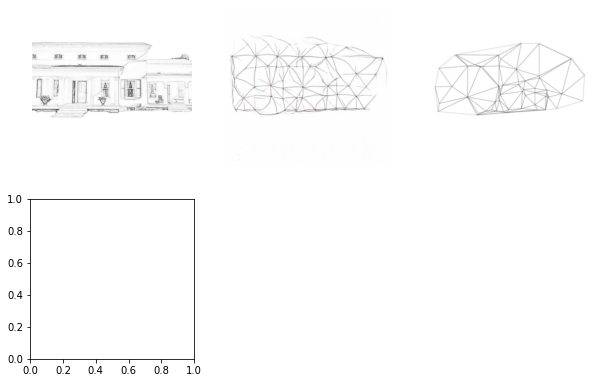

In [10]:
plt.figure(figsize=(10,10))

for ii in range(0,9,3):
    plt.subplot(3,3,ii+1)
    plt.imshow(to_pil_image(0.5*picture_imgs[ii]+0.5))
    plt.axis('off')
    plt.subplot(3,3,ii+2)
    plt.imshow(to_pil_image(0.5*fake_imgs[ii]+0.5))
    plt.axis('off')
    plt.subplot(3,3,ii+3)
    plt.imshow(to_pil_image(0.5*real_imgs[ii]+0.5))
    plt.axis('off')

In [11]:
path2models = 'model/'
#os.makedirs(path2models, exist_ok=True) #디렉토리 생성
path2weights_gen = os.path.join(path2models, 'weights_gen_b2a_0818.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis_b2a_0818.pt')

torch.save(G.state_dict(), path2weights_gen)#저장
torch.save(D.state_dict(), path2weights_dis)

In [10]:
# 가중치 불러오기
path2models = 'model/'
G = Generator(3, 64, 3)
G.cuda()
path2weights_gen2 = os.path.join(path2models, 'weights_gen_b2a_0818.pt')

weights = torch.load(path2weights_gen2)
G.load_state_dict(weights)

<All keys matched successfully>

In [7]:
# Custom dataset
from PIL import Image
import torch.utils.data as data
import os
import random


class DatasetFromFolder2(data.Dataset):
    def __init__(self, path2img, direction='AtoB', transform=False): #b2a : binary to ascii
        super().__init__()
        self.direction = direction
        self.path2a = 'C:/Users/Mobile/Desktop/woo/pix2pix-master/pix2pix-master/data/sample_origin'
        self.path2b = 'C:/Users/Mobile/Desktop/woo/pix2pix-master/pix2pix-master/data/sample_pattern'
        self.img_filenames = [x for x in listdir(self.path2a)]
        self.transform = transform

    def __getitem__(self, index):
        a = Image.open(join(self.path2a, self.img_filenames[index])).convert('RGB')
        b = Image.open(join(self.path2b, self.img_filenames[index])).convert('RGB')
        
        if self.transform:
            a = self.transform(a)
            b = self.transform(b)

        if self.direction == 'AtoB':
            return a,b
        else:
            return b,a

    def __len__(self):
        return len(self.img_filenames)

2846
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


(-0.5, 255.5, 255.5, -0.5)

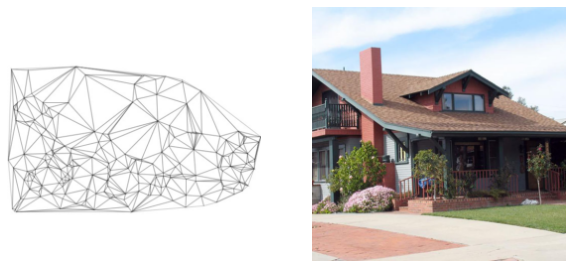

In [13]:
from PIL import ImageFile
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from os import listdir
from os.path import join
# Data pre-processing
transform = transforms.Compose([transforms.Scale(256),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                transforms.Resize((256,256))])

# Train data
data_dir ='./data/'
test_dir='./test/'
train_data2 = DatasetFromFolder2(data_dir, direction="BtoA", transform=transform
                               )
train_data_loader = torch.utils.data.DataLoader(dataset=train_data2,
                                                batch_size=32,
                                                shuffle=True)


test_data2=DatasetFromFolder2(test_dir, direction="BtoA",transform=transform)


print(len(train_data2))
a,b = train_data2[0]
print(train_data2[0][0])
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(a*0.5 + 0.5)) #tensor 데이터를 pil데이터로 변환

plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5*b+0.5))
plt.axis('off')


In [14]:
from os import listdir
from os.path import join
import torch
from torchvision import transforms
from torch.autograd import Variable
import argparse
import os

# Directories for loading data and saving results
data_dir ='./data/'
save_dir = 'results/'
model_dir = 'model/'

if not os.path.exists(save_dir):
    os.mkdir(save_dir)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

# Data pre-processing
transform = transforms.Compose([transforms.Scale(256),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                transforms.Resize((256,256))])

# Train data
train_data2 = DatasetFromFolder2(data_dir, direction="BtoA", transform=transform
                               )
train_data_loader2 = torch.utils.data.DataLoader(dataset=train_data2,
                                                batch_size=32,
                                                shuffle=True)



test_data_loader2 = torch.utils.data.DataLoader(dataset=test_data2,
                                               batch_size=2,
                                               shuffle=False)
test_input2, test_target2 = test_data_loader2.__iter__().__next__()



In [ ]:
G2 = Generator(3, 64, 3)
D2 = Discriminator(6, 64, 1)
G2.cuda()
D2.cuda()
G2.normal_weight_init(mean=0.0, std=0.02)
D2.normal_weight_init(mean=0.0, std=0.02)



# Loss function
BCE_loss = torch.nn.BCELoss().cuda()
L1_loss = torch.nn.L1Loss().cuda()

# Optimizers
G_optimizer2 = torch.optim.Adam(G2.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer2 = torch.optim.Adam(D2.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training GAN
D_avg_losses2 = []
G_avg_losses2 = []

step = 0
for epoch in range(100):
    D_losses2 = []
    G_losses2 = []

    # training
    for input, target in train_data_loader2:

        # input & target image data
        x_ = Variable(input.cuda())
        y_ = Variable(target.cuda())

        # Train discriminator with real data
        D_real_decision = D2(x_, y_).squeeze()
        real_ = Variable(torch.ones(D_real_decision.size()).cuda())
        D_real_loss = BCE_loss(D_real_decision, real_)

        # Train discriminator with fake data
        gen_image = G2(x_)
        D_fake_decision = D2(x_, gen_image).squeeze()
        fake_ = Variable(torch.zeros(D_fake_decision.size()).cuda())
        D_fake_loss = BCE_loss(D_fake_decision, fake_)

        # Back propagation
        D_loss2 = (D_real_loss + D_fake_loss) * 0.5
        D2.zero_grad()
        D_loss2.backward()
        D_optimizer2.step()

        # Train generator
        gen_image = G2(x_)
        D_fake_decision = D2(x_, gen_image).squeeze()
        G_fake_loss = BCE_loss(D_fake_decision, real_)

        # L1 loss
        l1_loss = 100* L1_loss(gen_image, y_)

        # Back propagation
        G_loss2 = G_fake_loss + l1_loss
        G2.zero_grad()
        G_loss2.backward()
        G_optimizer2.step()

        # loss values
        D_losses2.append(D_loss2.item())
        G_losses2.append(G_loss2.item())

        print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
              % (epoch+1, 100, step, len(train_data_loader2), D_loss2.data.item(), G_loss2.data.item()))

        step += 1

    D_avg_loss2 = torch.mean(torch.FloatTensor(D_losses2))
    G_avg_loss2 = torch.mean(torch.FloatTensor(G_losses2))

    # avg loss values for plot
    D_avg_losses2.append(D_avg_loss2)
    G_avg_losses2.append(G_avg_loss2)

    # Show result for test image
    

    



# Save trained parameters of model
torch.save(G2.state_dict(), model_dir + 'generator2_param.pkl')
torch.save(D2.state_dict(), model_dir + 'discriminator2_param.pkl')




In [23]:
# evaluation model
G2.eval()

# 가짜 이미지 생성
with torch.no_grad():
    for a,b in test_data_loader2:
        fake_imgs = G2(a.cuda().data).detach().cpu()
        real_imgs = b
        picture_imgs = a
        
# 가짜 이미지 시각화




IndexError: index 3 is out of bounds for dimension 0 with size 2

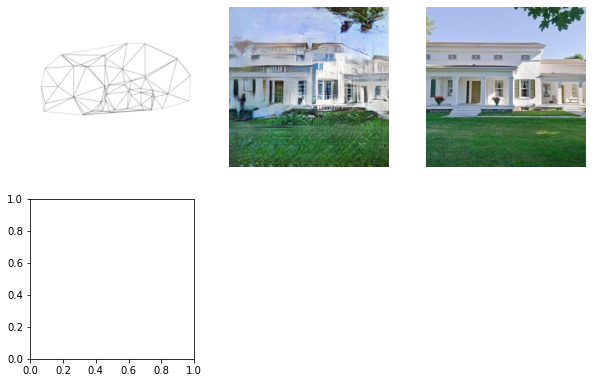

In [24]:
plt.figure(figsize=(10,10))

for ii in range(0,9,3):
    plt.subplot(3,3,ii+1)
    plt.imshow(to_pil_image(0.5*picture_imgs[ii]+0.5))
    plt.axis('off')
    plt.subplot(3,3,ii+2)
    plt.imshow(to_pil_image(0.5*fake_imgs[ii]+0.5))
    plt.axis('off')
    plt.subplot(3,3,ii+3)
    plt.imshow(to_pil_image(0.5*real_imgs[ii]+0.5))
    plt.axis('off')

In [ ]:
path2models = 'model/'
#os.makedirs(path2models, exist_ok=True) #디렉토리 생성
path2weights_gen2 = os.path.join(path2models, 'weights_gen2_b2a.pt')
path2weights_dis2 = os.path.join(path2models, 'weights_dis2_b2a.pt')

torch.save(G2.state_dict(), path2weights_gen2)#저장
torch.save(D2.state_dict(), path2weights_dis2)

IndexError: index 5 is out of bounds for dimension 0 with size 2

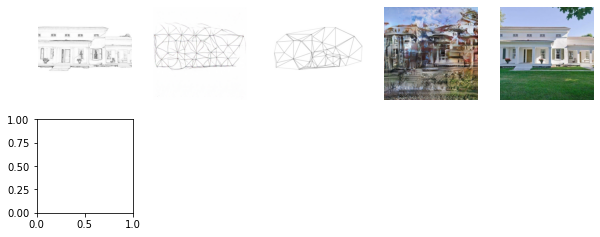

In [25]:
# evaluation model
G2.eval()

# 가짜 이미지 생성
with torch.no_grad():
    for a,b in test_data_loader:
        fake_imgs_1 = G(a.cuda().data).detach().cpu()
        real_imgs_1 = b
        picture_imgs = a
        
# 가짜 이미지 시각화

with torch.no_grad():
    for a,b in test_data_loader2:
        fake_imgs_2 = G2(fake_imgs_1.cuda().data).detach().cpu()
        real_imgs_2 = b
        picture_imgs_2 = a


plt.figure(figsize=(10,10))

for ii in range(0,25,5):
    plt.subplot(5,5,ii+1)
    plt.imshow(to_pil_image(0.5*picture_imgs[ii]+0.5))
    plt.axis('off')
    plt.subplot(5,5,ii+2)
    plt.imshow(to_pil_image(0.5*fake_imgs_1[ii]+0.5))
    plt.axis('off')
    plt.subplot(5,5,ii+3)
    plt.imshow(to_pil_image(0.5*real_imgs_1[ii]+0.5))
    plt.axis('off')
    plt.subplot(5,5,ii+4)
    plt.imshow(to_pil_image(0.5*fake_imgs_2[ii]+0.5))
    plt.axis('off')
    plt.subplot(5,5,ii+5)
    plt.imshow(to_pil_image(0.5*real_imgs_2[ii]+0.5))
    plt.axis('off')



In [ ]:


# Models
G3 = Generator(3, 64, 3)
D3 = Discriminator(6, 64, 1)
G3.cuda()
D3.cuda()
G3.normal_weight_init(mean=0.0, std=0.02)
D3.normal_weight_init(mean=0.0, std=0.02)



# Loss function
BCE_loss = torch.nn.BCELoss().cuda()
L1_loss = torch.nn.L1Loss().cuda()

# Optimizers
G_optimizer3 = torch.optim.Adam(G3.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer3 = torch.optim.Adam(D3.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training GAN
D_avg_losses3 = []
G_avg_losses3 = []

step = 0
for epoch in range(100):
    D_losses3 = []
    G_losses3 = []

    # training
    for input, target in train_data_loader2:

        # input & target image data
        
        x_ = Variable(input.cuda())
        x_ =G (x_.data).detach()
        x_=Variable(x_.cuda())
        y_ = Variable(target.cuda())
        
        
        # Train discriminator with real data
        D_real_decision = D3(x_, y_).squeeze()
        real_ = Variable(torch.ones(D_real_decision.size()).cuda())
        D_real_loss = BCE_loss(D_real_decision, real_)

        # Train discriminator with fake data
        gen_image = G3(x_)
        D_fake_decision = D3(x_, gen_image).squeeze()
        fake_ = Variable(torch.zeros(D_fake_decision.size()).cuda())
        D_fake_loss = BCE_loss(D_fake_decision, fake_)

        # Back propagation
        D_loss3 = (D_real_loss + D_fake_loss) * 0.5
        D3.zero_grad()
        D_loss3.backward()
        D_optimizer3.step()

        # Train generator
        gen_image = G3(x_)
        D_fake_decision = D3(x_, gen_image).squeeze()
        G_fake_loss = BCE_loss(D_fake_decision, real_)

        # L1 loss
        l1_loss = 100* L1_loss(gen_image, y_)

        # Back propagation
        G_loss3 = G_fake_loss + l1_loss
        G3.zero_grad()
        G_loss3.backward()
        G_optimizer3.step()

        # loss values
        D_losses3.append(D_loss3.item())
        G_losses3.append(G_loss3.item())

        print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
              % (epoch+1, 100, step, len(train_data_loader2), D_loss3.data.item(), G_loss3.data.item()))

        step += 1

    D_avg_loss3 = torch.mean(torch.FloatTensor(D_losses3))
    G_avg_loss3 = torch.mean(torch.FloatTensor(G_losses3))

    # avg loss values for plot
    D_avg_losses3.append(D_avg_loss3)
    G_avg_losses3.append(G_avg_loss3)

    # Show result for test image
    

    



# Save trained parameters of model
torch.save(G3.state_dict(), model_dir + 'generator3_param_0818.pkl')
torch.save(D3.state_dict(), model_dir + 'discriminator3_param_0818.pkl')





C:\Users\Mobile\AppData\Local\Temp/ipykernel_24936/1730421462.py:102: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.conv.weight, mean, std)
C:\Users\Mobile\AppData\Local\Temp/ipykernel_24936/1730421462.py:104: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.deconv.weight, mean, std)
C:\Users\Mobile\AppData\Local\Temp/ipykernel_24936/1730421462.py:185: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.conv.weight, mean, std)


Epoch [1/100], Step [0/89], D_loss: 0.8669, G_loss: 53.9460
Epoch [1/100], Step [1/89], D_loss: 1.3965, G_loss: 48.4916
Epoch [1/100], Step [2/89], D_loss: 0.8224, G_loss: 50.9251
Epoch [1/100], Step [3/89], D_loss: 0.8450, G_loss: 52.1909
Epoch [1/100], Step [4/89], D_loss: 0.7573, G_loss: 48.6273
Epoch [1/100], Step [5/89], D_loss: 0.6914, G_loss: 49.8042
Epoch [1/100], Step [6/89], D_loss: 0.6524, G_loss: 44.6644
Epoch [1/100], Step [7/89], D_loss: 0.6162, G_loss: 48.8094
Epoch [1/100], Step [8/89], D_loss: 0.5709, G_loss: 45.1899
Epoch [1/100], Step [9/89], D_loss: 0.5296, G_loss: 45.6132
Epoch [1/100], Step [10/89], D_loss: 0.5056, G_loss: 45.5426
Epoch [1/100], Step [11/89], D_loss: 0.5832, G_loss: 49.2734
Epoch [1/100], Step [12/89], D_loss: 0.7519, G_loss: 45.2475
Epoch [1/100], Step [13/89], D_loss: 0.5785, G_loss: 47.0488
Epoch [1/100], Step [14/89], D_loss: 0.4350, G_loss: 46.1213
Epoch [1/100], Step [15/89], D_loss: 0.3861, G_loss: 44.3158
Epoch [1/100], Step [16/89], D_los

Epoch [2/100], Step [134/89], D_loss: 0.0746, G_loss: 46.8997
Epoch [2/100], Step [135/89], D_loss: 0.1043, G_loss: 48.6397
Epoch [2/100], Step [136/89], D_loss: 0.1628, G_loss: 45.4506
Epoch [2/100], Step [137/89], D_loss: 0.1481, G_loss: 46.8625
Epoch [2/100], Step [138/89], D_loss: 0.2058, G_loss: 46.8226
Epoch [2/100], Step [139/89], D_loss: 0.1742, G_loss: 46.5369
Epoch [2/100], Step [140/89], D_loss: 0.1265, G_loss: 45.7491
Epoch [2/100], Step [141/89], D_loss: 0.0759, G_loss: 50.0466
Epoch [2/100], Step [142/89], D_loss: 0.1027, G_loss: 47.0359
Epoch [2/100], Step [143/89], D_loss: 0.0753, G_loss: 47.4294
Epoch [2/100], Step [144/89], D_loss: 0.0650, G_loss: 48.7781
Epoch [2/100], Step [145/89], D_loss: 0.0802, G_loss: 44.7874
Epoch [2/100], Step [146/89], D_loss: 0.0994, G_loss: 46.1887
Epoch [2/100], Step [147/89], D_loss: 0.0762, G_loss: 50.1618
Epoch [2/100], Step [148/89], D_loss: 0.0734, G_loss: 48.4706
Epoch [2/100], Step [149/89], D_loss: 0.1136, G_loss: 51.2311
Epoch [2

Epoch [4/100], Step [267/89], D_loss: 0.0727, G_loss: 46.7968
Epoch [4/100], Step [268/89], D_loss: 0.2160, G_loss: 47.5496
Epoch [4/100], Step [269/89], D_loss: 0.1272, G_loss: 46.9521
Epoch [4/100], Step [270/89], D_loss: 0.0748, G_loss: 49.1612
Epoch [4/100], Step [271/89], D_loss: 0.0803, G_loss: 47.4439
Epoch [4/100], Step [272/89], D_loss: 0.1307, G_loss: 47.5066
Epoch [4/100], Step [273/89], D_loss: 0.1377, G_loss: 48.2459
Epoch [4/100], Step [274/89], D_loss: 0.1899, G_loss: 46.2274
Epoch [4/100], Step [275/89], D_loss: 0.0786, G_loss: 47.3910
Epoch [4/100], Step [276/89], D_loss: 0.1317, G_loss: 48.1241
Epoch [4/100], Step [277/89], D_loss: 0.1618, G_loss: 47.0895
Epoch [4/100], Step [278/89], D_loss: 0.1092, G_loss: 44.5761
Epoch [4/100], Step [279/89], D_loss: 0.1004, G_loss: 43.8989
Epoch [4/100], Step [280/89], D_loss: 0.3975, G_loss: 51.8931
Epoch [4/100], Step [281/89], D_loss: 0.8583, G_loss: 46.3412
Epoch [4/100], Step [282/89], D_loss: 0.4547, G_loss: 47.8944
Epoch [4

Epoch [5/100], Step [400/89], D_loss: 0.5963, G_loss: 46.3185
Epoch [5/100], Step [401/89], D_loss: 0.2266, G_loss: 47.8464
Epoch [5/100], Step [402/89], D_loss: 0.3193, G_loss: 44.6942
Epoch [5/100], Step [403/89], D_loss: 0.2529, G_loss: 45.5891
Epoch [5/100], Step [404/89], D_loss: 0.1423, G_loss: 45.0715
Epoch [5/100], Step [405/89], D_loss: 0.1343, G_loss: 46.4958
Epoch [5/100], Step [406/89], D_loss: 0.2259, G_loss: 48.3207
Epoch [5/100], Step [407/89], D_loss: 0.1814, G_loss: 49.3380
Epoch [5/100], Step [408/89], D_loss: 0.1851, G_loss: 45.4996
Epoch [5/100], Step [409/89], D_loss: 0.2056, G_loss: 47.5590
Epoch [5/100], Step [410/89], D_loss: 0.1618, G_loss: 48.2838
Epoch [5/100], Step [411/89], D_loss: 0.5142, G_loss: 45.6491
Epoch [5/100], Step [412/89], D_loss: 0.3297, G_loss: 46.6042
Epoch [5/100], Step [413/89], D_loss: 0.1097, G_loss: 46.8938
Epoch [5/100], Step [414/89], D_loss: 0.1085, G_loss: 46.5970
Epoch [5/100], Step [415/89], D_loss: 0.1346, G_loss: 46.0402
Epoch [5

Epoch [6/100], Step [533/89], D_loss: 0.1372, G_loss: 44.5565
Epoch [7/100], Step [534/89], D_loss: 0.2842, G_loss: 45.9042
Epoch [7/100], Step [535/89], D_loss: 0.5033, G_loss: 41.7662
Epoch [7/100], Step [536/89], D_loss: 0.6327, G_loss: 48.0697
Epoch [7/100], Step [537/89], D_loss: 0.5754, G_loss: 44.8331
Epoch [7/100], Step [538/89], D_loss: 0.1582, G_loss: 45.9241
Epoch [7/100], Step [539/89], D_loss: 0.3683, G_loss: 46.7687
Epoch [7/100], Step [540/89], D_loss: 0.4480, G_loss: 44.4978
Epoch [7/100], Step [541/89], D_loss: 0.1838, G_loss: 48.6793
Epoch [7/100], Step [542/89], D_loss: 0.2137, G_loss: 41.9441
Epoch [7/100], Step [543/89], D_loss: 0.3390, G_loss: 48.6318
Epoch [7/100], Step [544/89], D_loss: 0.4256, G_loss: 43.8401
Epoch [7/100], Step [545/89], D_loss: 0.1990, G_loss: 42.8630
Epoch [7/100], Step [546/89], D_loss: 0.2255, G_loss: 47.2392
Epoch [7/100], Step [547/89], D_loss: 0.4120, G_loss: 43.8169
Epoch [7/100], Step [548/89], D_loss: 0.3716, G_loss: 47.3226
Epoch [7

Epoch [8/100], Step [666/89], D_loss: 0.1980, G_loss: 47.1923
Epoch [8/100], Step [667/89], D_loss: 0.4228, G_loss: 41.2603
Epoch [8/100], Step [668/89], D_loss: 0.7938, G_loss: 48.9544
Epoch [8/100], Step [669/89], D_loss: 1.0064, G_loss: 43.4792
Epoch [8/100], Step [670/89], D_loss: 0.2390, G_loss: 44.2153
Epoch [8/100], Step [671/89], D_loss: 0.2634, G_loss: 44.5927
Epoch [8/100], Step [672/89], D_loss: 0.4401, G_loss: 44.0055
Epoch [8/100], Step [673/89], D_loss: 0.2021, G_loss: 43.5694
Epoch [8/100], Step [674/89], D_loss: 0.1498, G_loss: 45.2839
Epoch [8/100], Step [675/89], D_loss: 0.2795, G_loss: 44.1045
Epoch [8/100], Step [676/89], D_loss: 0.2516, G_loss: 44.6524
Epoch [8/100], Step [677/89], D_loss: 0.3027, G_loss: 43.3145
Epoch [8/100], Step [678/89], D_loss: 0.1570, G_loss: 45.4357
Epoch [8/100], Step [679/89], D_loss: 0.3502, G_loss: 43.3115
Epoch [8/100], Step [680/89], D_loss: 0.1714, G_loss: 46.4164
Epoch [8/100], Step [681/89], D_loss: 0.3277, G_loss: 41.6026
Epoch [8

Epoch [9/100], Step [799/89], D_loss: 0.2575, G_loss: 46.6149
Epoch [9/100], Step [800/89], D_loss: 0.4671, G_loss: 46.4450
Epoch [10/100], Step [801/89], D_loss: 0.4768, G_loss: 45.0726
Epoch [10/100], Step [802/89], D_loss: 0.7927, G_loss: 42.0981
Epoch [10/100], Step [803/89], D_loss: 0.2792, G_loss: 42.6455
Epoch [10/100], Step [804/89], D_loss: 0.3249, G_loss: 41.4052
Epoch [10/100], Step [805/89], D_loss: 0.2664, G_loss: 43.4228
Epoch [10/100], Step [806/89], D_loss: 0.5739, G_loss: 40.7322
Epoch [10/100], Step [807/89], D_loss: 0.5185, G_loss: 44.7019
Epoch [10/100], Step [808/89], D_loss: 0.3947, G_loss: 41.0867
Epoch [10/100], Step [809/89], D_loss: 0.2358, G_loss: 40.3184
Epoch [10/100], Step [810/89], D_loss: 0.2003, G_loss: 45.9875
Epoch [10/100], Step [811/89], D_loss: 0.5590, G_loss: 40.7287
Epoch [10/100], Step [812/89], D_loss: 0.3723, G_loss: 41.8940
Epoch [10/100], Step [813/89], D_loss: 0.2921, G_loss: 42.0056
Epoch [10/100], Step [814/89], D_loss: 0.2532, G_loss: 43

Epoch [11/100], Step [930/89], D_loss: 0.6217, G_loss: 40.3410
Epoch [11/100], Step [931/89], D_loss: 0.3191, G_loss: 42.1993
Epoch [11/100], Step [932/89], D_loss: 0.2568, G_loss: 41.6826
Epoch [11/100], Step [933/89], D_loss: 0.2385, G_loss: 44.8622
Epoch [11/100], Step [934/89], D_loss: 0.2271, G_loss: 39.0059
Epoch [11/100], Step [935/89], D_loss: 0.2864, G_loss: 42.7057
Epoch [11/100], Step [936/89], D_loss: 0.4442, G_loss: 42.9659
Epoch [11/100], Step [937/89], D_loss: 0.3477, G_loss: 41.4667
Epoch [11/100], Step [938/89], D_loss: 0.5229, G_loss: 40.4709
Epoch [11/100], Step [939/89], D_loss: 0.4227, G_loss: 41.6430
Epoch [11/100], Step [940/89], D_loss: 0.4160, G_loss: 44.2905
Epoch [11/100], Step [941/89], D_loss: 0.5330, G_loss: 41.0197
Epoch [11/100], Step [942/89], D_loss: 0.3653, G_loss: 42.5378
Epoch [11/100], Step [943/89], D_loss: 0.1894, G_loss: 43.1043
Epoch [11/100], Step [944/89], D_loss: 0.2229, G_loss: 41.6640
Epoch [11/100], Step [945/89], D_loss: 0.4191, G_loss: 

Epoch [12/100], Step [1060/89], D_loss: 0.6146, G_loss: 42.5520
Epoch [12/100], Step [1061/89], D_loss: 0.5268, G_loss: 40.1841
Epoch [12/100], Step [1062/89], D_loss: 0.1456, G_loss: 42.4885
Epoch [12/100], Step [1063/89], D_loss: 0.1870, G_loss: 39.8692
Epoch [12/100], Step [1064/89], D_loss: 0.3194, G_loss: 44.3385
Epoch [12/100], Step [1065/89], D_loss: 0.7829, G_loss: 40.1814
Epoch [12/100], Step [1066/89], D_loss: 0.4509, G_loss: 43.9423
Epoch [12/100], Step [1067/89], D_loss: 0.2060, G_loss: 41.4764
Epoch [13/100], Step [1068/89], D_loss: 0.1729, G_loss: 38.3383
Epoch [13/100], Step [1069/89], D_loss: 0.3923, G_loss: 40.5347
Epoch [13/100], Step [1070/89], D_loss: 0.7431, G_loss: 39.2483
Epoch [13/100], Step [1071/89], D_loss: 0.2433, G_loss: 39.9324
Epoch [13/100], Step [1072/89], D_loss: 0.2166, G_loss: 40.3390
Epoch [13/100], Step [1073/89], D_loss: 0.2231, G_loss: 39.5984
Epoch [13/100], Step [1074/89], D_loss: 0.2417, G_loss: 37.8386
Epoch [13/100], Step [1075/89], D_loss: 

Epoch [14/100], Step [1189/89], D_loss: 0.3431, G_loss: 39.5706
Epoch [14/100], Step [1190/89], D_loss: 0.2602, G_loss: 41.0506
Epoch [14/100], Step [1191/89], D_loss: 0.2170, G_loss: 38.9508
Epoch [14/100], Step [1192/89], D_loss: 0.3071, G_loss: 37.7963
Epoch [14/100], Step [1193/89], D_loss: 0.3027, G_loss: 41.0537
Epoch [14/100], Step [1194/89], D_loss: 0.5599, G_loss: 38.9104
Epoch [14/100], Step [1195/89], D_loss: 0.5101, G_loss: 40.1532
Epoch [14/100], Step [1196/89], D_loss: 0.5171, G_loss: 39.7749
Epoch [14/100], Step [1197/89], D_loss: 0.4067, G_loss: 39.3351
Epoch [14/100], Step [1198/89], D_loss: 0.3755, G_loss: 38.2134
Epoch [14/100], Step [1199/89], D_loss: 0.3264, G_loss: 40.5432
Epoch [14/100], Step [1200/89], D_loss: 0.3298, G_loss: 38.2803
Epoch [14/100], Step [1201/89], D_loss: 0.4004, G_loss: 41.0439
Epoch [14/100], Step [1202/89], D_loss: 0.4961, G_loss: 37.5114
Epoch [14/100], Step [1203/89], D_loss: 0.4835, G_loss: 39.1923
Epoch [14/100], Step [1204/89], D_loss: 

Epoch [15/100], Step [1318/89], D_loss: 0.3516, G_loss: 37.4827
Epoch [15/100], Step [1319/89], D_loss: 0.2270, G_loss: 37.9790
Epoch [15/100], Step [1320/89], D_loss: 0.2697, G_loss: 39.8489
Epoch [15/100], Step [1321/89], D_loss: 0.4661, G_loss: 39.1705
Epoch [15/100], Step [1322/89], D_loss: 0.3882, G_loss: 37.9715
Epoch [15/100], Step [1323/89], D_loss: 0.3379, G_loss: 37.4917
Epoch [15/100], Step [1324/89], D_loss: 0.4029, G_loss: 37.9209
Epoch [15/100], Step [1325/89], D_loss: 0.4420, G_loss: 39.4396
Epoch [15/100], Step [1326/89], D_loss: 0.3926, G_loss: 35.7100
Epoch [15/100], Step [1327/89], D_loss: 0.4034, G_loss: 37.7783
Epoch [15/100], Step [1328/89], D_loss: 0.5323, G_loss: 35.5399
Epoch [15/100], Step [1329/89], D_loss: 0.3906, G_loss: 40.3857
Epoch [15/100], Step [1330/89], D_loss: 0.3166, G_loss: 38.2324
Epoch [15/100], Step [1331/89], D_loss: 0.4096, G_loss: 37.0407
Epoch [15/100], Step [1332/89], D_loss: 0.5920, G_loss: 42.1087
Epoch [15/100], Step [1333/89], D_loss: 

Epoch [17/100], Step [1447/89], D_loss: 0.6857, G_loss: 35.2394
Epoch [17/100], Step [1448/89], D_loss: 0.3692, G_loss: 34.1960
Epoch [17/100], Step [1449/89], D_loss: 0.3368, G_loss: 40.4164
Epoch [17/100], Step [1450/89], D_loss: 0.6357, G_loss: 39.1443
Epoch [17/100], Step [1451/89], D_loss: 0.3383, G_loss: 37.3529
Epoch [17/100], Step [1452/89], D_loss: 0.1646, G_loss: 36.7142
Epoch [17/100], Step [1453/89], D_loss: 0.2518, G_loss: 37.2025
Epoch [17/100], Step [1454/89], D_loss: 0.2552, G_loss: 39.4307
Epoch [17/100], Step [1455/89], D_loss: 0.8111, G_loss: 37.6027
Epoch [17/100], Step [1456/89], D_loss: 0.4846, G_loss: 37.9465
Epoch [17/100], Step [1457/89], D_loss: 0.1179, G_loss: 39.7953
Epoch [17/100], Step [1458/89], D_loss: 0.4264, G_loss: 34.4391
Epoch [17/100], Step [1459/89], D_loss: 0.5690, G_loss: 40.3529
Epoch [17/100], Step [1460/89], D_loss: 0.4937, G_loss: 36.3635
Epoch [17/100], Step [1461/89], D_loss: 0.4076, G_loss: 38.6516
Epoch [17/100], Step [1462/89], D_loss: 

Epoch [18/100], Step [1576/89], D_loss: 0.7050, G_loss: 35.8763
Epoch [18/100], Step [1577/89], D_loss: 0.3467, G_loss: 35.1421
Epoch [18/100], Step [1578/89], D_loss: 0.2769, G_loss: 36.9699
Epoch [18/100], Step [1579/89], D_loss: 0.5518, G_loss: 35.0447
Epoch [18/100], Step [1580/89], D_loss: 0.3601, G_loss: 38.2284
Epoch [18/100], Step [1581/89], D_loss: 0.3270, G_loss: 36.1079
Epoch [18/100], Step [1582/89], D_loss: 0.2188, G_loss: 36.5898
Epoch [18/100], Step [1583/89], D_loss: 0.3511, G_loss: 37.0587
Epoch [18/100], Step [1584/89], D_loss: 0.3869, G_loss: 35.4131
Epoch [18/100], Step [1585/89], D_loss: 0.6906, G_loss: 35.1592
Epoch [18/100], Step [1586/89], D_loss: 0.3979, G_loss: 35.5019
Epoch [18/100], Step [1587/89], D_loss: 0.2253, G_loss: 36.1042
Epoch [18/100], Step [1588/89], D_loss: 0.1776, G_loss: 38.6563
Epoch [18/100], Step [1589/89], D_loss: 0.2963, G_loss: 37.5481
Epoch [18/100], Step [1590/89], D_loss: 0.3707, G_loss: 36.1515
Epoch [18/100], Step [1591/89], D_loss: 

Epoch [20/100], Step [1705/89], D_loss: 0.4415, G_loss: 33.9169
Epoch [20/100], Step [1706/89], D_loss: 0.2219, G_loss: 34.6826
Epoch [20/100], Step [1707/89], D_loss: 0.2806, G_loss: 37.1341
Epoch [20/100], Step [1708/89], D_loss: 0.2950, G_loss: 35.7221
Epoch [20/100], Step [1709/89], D_loss: 0.3732, G_loss: 34.8694
Epoch [20/100], Step [1710/89], D_loss: 0.5918, G_loss: 32.7431
Epoch [20/100], Step [1711/89], D_loss: 0.4994, G_loss: 38.4010
Epoch [20/100], Step [1712/89], D_loss: 0.4519, G_loss: 35.7161
Epoch [20/100], Step [1713/89], D_loss: 0.3727, G_loss: 33.4743
Epoch [20/100], Step [1714/89], D_loss: 0.3686, G_loss: 36.0125
Epoch [20/100], Step [1715/89], D_loss: 0.2890, G_loss: 33.0187
Epoch [20/100], Step [1716/89], D_loss: 0.4430, G_loss: 33.8444
Epoch [20/100], Step [1717/89], D_loss: 0.6453, G_loss: 36.0109
Epoch [20/100], Step [1718/89], D_loss: 0.7530, G_loss: 35.4392
Epoch [20/100], Step [1719/89], D_loss: 0.4785, G_loss: 34.2689
Epoch [20/100], Step [1720/89], D_loss: 

Epoch [21/100], Step [1834/89], D_loss: 0.3018, G_loss: 34.3697
Epoch [21/100], Step [1835/89], D_loss: 0.4171, G_loss: 31.9678
Epoch [21/100], Step [1836/89], D_loss: 0.3443, G_loss: 35.5023
Epoch [21/100], Step [1837/89], D_loss: 0.9378, G_loss: 33.1104
Epoch [21/100], Step [1838/89], D_loss: 0.4141, G_loss: 35.8321
Epoch [21/100], Step [1839/89], D_loss: 0.4064, G_loss: 34.8982
Epoch [21/100], Step [1840/89], D_loss: 0.3312, G_loss: 33.4469
Epoch [21/100], Step [1841/89], D_loss: 0.4874, G_loss: 36.3569
Epoch [21/100], Step [1842/89], D_loss: 0.5500, G_loss: 36.8712
Epoch [21/100], Step [1843/89], D_loss: 0.5948, G_loss: 32.8595
Epoch [21/100], Step [1844/89], D_loss: 0.5039, G_loss: 34.3503
Epoch [21/100], Step [1845/89], D_loss: 0.2153, G_loss: 33.6513
Epoch [21/100], Step [1846/89], D_loss: 0.3195, G_loss: 35.8432
Epoch [21/100], Step [1847/89], D_loss: 0.5124, G_loss: 34.6108
Epoch [21/100], Step [1848/89], D_loss: 0.3930, G_loss: 33.5208
Epoch [21/100], Step [1849/89], D_loss: 

Epoch [23/100], Step [1963/89], D_loss: 0.3624, G_loss: 33.6737
Epoch [23/100], Step [1964/89], D_loss: 0.6649, G_loss: 31.3380
Epoch [23/100], Step [1965/89], D_loss: 0.4667, G_loss: 34.4708
Epoch [23/100], Step [1966/89], D_loss: 0.3731, G_loss: 32.6446
Epoch [23/100], Step [1967/89], D_loss: 0.4740, G_loss: 30.5298
Epoch [23/100], Step [1968/89], D_loss: 0.3810, G_loss: 31.0586
Epoch [23/100], Step [1969/89], D_loss: 0.3352, G_loss: 31.6295
Epoch [23/100], Step [1970/89], D_loss: 0.4967, G_loss: 31.9898
Epoch [23/100], Step [1971/89], D_loss: 0.5183, G_loss: 36.7943
Epoch [23/100], Step [1972/89], D_loss: 0.8221, G_loss: 31.0969
Epoch [23/100], Step [1973/89], D_loss: 0.3124, G_loss: 32.6106
Epoch [23/100], Step [1974/89], D_loss: 0.3098, G_loss: 32.2704
Epoch [23/100], Step [1975/89], D_loss: 0.2970, G_loss: 32.4419
Epoch [23/100], Step [1976/89], D_loss: 0.6370, G_loss: 32.5866
Epoch [23/100], Step [1977/89], D_loss: 0.4693, G_loss: 34.6869
Epoch [23/100], Step [1978/89], D_loss: 

Epoch [24/100], Step [2092/89], D_loss: 0.6764, G_loss: 30.6110
Epoch [24/100], Step [2093/89], D_loss: 0.7921, G_loss: 36.6571
Epoch [24/100], Step [2094/89], D_loss: 1.1105, G_loss: 31.5719
Epoch [24/100], Step [2095/89], D_loss: 0.4190, G_loss: 32.5441
Epoch [24/100], Step [2096/89], D_loss: 0.4985, G_loss: 32.5041
Epoch [24/100], Step [2097/89], D_loss: 0.6262, G_loss: 30.9980
Epoch [24/100], Step [2098/89], D_loss: 0.2974, G_loss: 30.6871
Epoch [24/100], Step [2099/89], D_loss: 0.3584, G_loss: 31.4582
Epoch [24/100], Step [2100/89], D_loss: 0.3963, G_loss: 30.9014
Epoch [24/100], Step [2101/89], D_loss: 0.5837, G_loss: 31.0898
Epoch [24/100], Step [2102/89], D_loss: 0.3260, G_loss: 31.4592
Epoch [24/100], Step [2103/89], D_loss: 0.3911, G_loss: 35.2704
Epoch [24/100], Step [2104/89], D_loss: 0.4409, G_loss: 33.4088
Epoch [24/100], Step [2105/89], D_loss: 0.3108, G_loss: 32.0608
Epoch [24/100], Step [2106/89], D_loss: 0.3310, G_loss: 33.1746
Epoch [24/100], Step [2107/89], D_loss: 

Epoch [25/100], Step [2221/89], D_loss: 0.4226, G_loss: 31.8302
Epoch [25/100], Step [2222/89], D_loss: 0.2364, G_loss: 32.4357
Epoch [25/100], Step [2223/89], D_loss: 0.3023, G_loss: 31.5693
Epoch [25/100], Step [2224/89], D_loss: 0.3373, G_loss: 31.5440
Epoch [26/100], Step [2225/89], D_loss: 0.8451, G_loss: 29.6273
Epoch [26/100], Step [2226/89], D_loss: 0.6659, G_loss: 32.0002
Epoch [26/100], Step [2227/89], D_loss: 0.4622, G_loss: 30.6656
Epoch [26/100], Step [2228/89], D_loss: 0.3566, G_loss: 32.3840
Epoch [26/100], Step [2229/89], D_loss: 0.2965, G_loss: 34.0840
Epoch [26/100], Step [2230/89], D_loss: 0.6783, G_loss: 32.3203
Epoch [26/100], Step [2231/89], D_loss: 0.4545, G_loss: 33.0329
Epoch [26/100], Step [2232/89], D_loss: 0.4838, G_loss: 30.8849
Epoch [26/100], Step [2233/89], D_loss: 0.3921, G_loss: 31.0959
Epoch [26/100], Step [2234/89], D_loss: 0.4093, G_loss: 30.8298
Epoch [26/100], Step [2235/89], D_loss: 0.5636, G_loss: 31.4667
Epoch [26/100], Step [2236/89], D_loss: 

Epoch [27/100], Step [2350/89], D_loss: 0.6779, G_loss: 32.8860
Epoch [27/100], Step [2351/89], D_loss: 0.7195, G_loss: 32.3688
Epoch [27/100], Step [2352/89], D_loss: 0.4477, G_loss: 33.3179
Epoch [27/100], Step [2353/89], D_loss: 0.3098, G_loss: 31.2314
Epoch [27/100], Step [2354/89], D_loss: 0.4342, G_loss: 29.9712
Epoch [27/100], Step [2355/89], D_loss: 0.4031, G_loss: 30.7028
Epoch [27/100], Step [2356/89], D_loss: 0.4180, G_loss: 30.6422
Epoch [27/100], Step [2357/89], D_loss: 0.2724, G_loss: 29.5533
Epoch [27/100], Step [2358/89], D_loss: 0.4570, G_loss: 28.6073
Epoch [27/100], Step [2359/89], D_loss: 0.3797, G_loss: 31.2836
Epoch [27/100], Step [2360/89], D_loss: 0.4527, G_loss: 32.6223
Epoch [27/100], Step [2361/89], D_loss: 0.6732, G_loss: 33.4585
Epoch [27/100], Step [2362/89], D_loss: 0.8134, G_loss: 33.3607
Epoch [27/100], Step [2363/89], D_loss: 0.3422, G_loss: 31.5680
Epoch [27/100], Step [2364/89], D_loss: 0.3729, G_loss: 31.4036
Epoch [27/100], Step [2365/89], D_loss: 

Epoch [28/100], Step [2479/89], D_loss: 0.6662, G_loss: 34.3971
Epoch [28/100], Step [2480/89], D_loss: 0.5299, G_loss: 30.4684
Epoch [28/100], Step [2481/89], D_loss: 0.4439, G_loss: 30.3865
Epoch [28/100], Step [2482/89], D_loss: 0.4522, G_loss: 36.2133
Epoch [28/100], Step [2483/89], D_loss: 0.6484, G_loss: 31.2598
Epoch [28/100], Step [2484/89], D_loss: 0.3011, G_loss: 32.2424
Epoch [28/100], Step [2485/89], D_loss: 0.5457, G_loss: 32.7308
Epoch [28/100], Step [2486/89], D_loss: 0.4576, G_loss: 33.0262
Epoch [28/100], Step [2487/89], D_loss: 0.5609, G_loss: 29.8982
Epoch [28/100], Step [2488/89], D_loss: 0.6636, G_loss: 31.3437
Epoch [28/100], Step [2489/89], D_loss: 0.3720, G_loss: 30.8984
Epoch [28/100], Step [2490/89], D_loss: 0.5679, G_loss: 29.7734
Epoch [28/100], Step [2491/89], D_loss: 0.4696, G_loss: 32.4461
Epoch [29/100], Step [2492/89], D_loss: 0.3471, G_loss: 30.1405
Epoch [29/100], Step [2493/89], D_loss: 0.3862, G_loss: 31.4199
Epoch [29/100], Step [2494/89], D_loss: 

Epoch [30/100], Step [2608/89], D_loss: 0.3726, G_loss: 30.0663
Epoch [30/100], Step [2609/89], D_loss: 0.5165, G_loss: 30.9375
Epoch [30/100], Step [2610/89], D_loss: 0.5717, G_loss: 29.5990
Epoch [30/100], Step [2611/89], D_loss: 0.4661, G_loss: 31.8033
Epoch [30/100], Step [2612/89], D_loss: 0.4002, G_loss: 31.4054
Epoch [30/100], Step [2613/89], D_loss: 0.2201, G_loss: 29.9950
Epoch [30/100], Step [2614/89], D_loss: 0.3129, G_loss: 32.1221
Epoch [30/100], Step [2615/89], D_loss: 0.3617, G_loss: 29.1002
Epoch [30/100], Step [2616/89], D_loss: 0.4957, G_loss: 33.3231
Epoch [30/100], Step [2617/89], D_loss: 0.5639, G_loss: 29.7366
Epoch [30/100], Step [2618/89], D_loss: 0.4680, G_loss: 30.0315
Epoch [30/100], Step [2619/89], D_loss: 0.6516, G_loss: 30.5918
Epoch [30/100], Step [2620/89], D_loss: 0.5089, G_loss: 29.3531
Epoch [30/100], Step [2621/89], D_loss: 0.5109, G_loss: 28.6874
Epoch [30/100], Step [2622/89], D_loss: 0.2804, G_loss: 29.3783
Epoch [30/100], Step [2623/89], D_loss: 

Epoch [31/100], Step [2737/89], D_loss: 0.4523, G_loss: 28.4748
Epoch [31/100], Step [2738/89], D_loss: 0.3040, G_loss: 30.5111
Epoch [31/100], Step [2739/89], D_loss: 0.3905, G_loss: 29.5259
Epoch [31/100], Step [2740/89], D_loss: 0.4724, G_loss: 30.4526
Epoch [31/100], Step [2741/89], D_loss: 0.3391, G_loss: 30.4254
Epoch [31/100], Step [2742/89], D_loss: 0.5639, G_loss: 28.0883
Epoch [31/100], Step [2743/89], D_loss: 0.3064, G_loss: 28.6204
Epoch [31/100], Step [2744/89], D_loss: 0.3450, G_loss: 28.2407
Epoch [31/100], Step [2745/89], D_loss: 0.4595, G_loss: 29.3862
Epoch [31/100], Step [2746/89], D_loss: 0.5833, G_loss: 30.3862
Epoch [31/100], Step [2747/89], D_loss: 0.4231, G_loss: 29.3934
Epoch [31/100], Step [2748/89], D_loss: 0.3693, G_loss: 30.4283
Epoch [31/100], Step [2749/89], D_loss: 0.5464, G_loss: 29.0014
Epoch [31/100], Step [2750/89], D_loss: 0.4531, G_loss: 29.6110
Epoch [31/100], Step [2751/89], D_loss: 0.3206, G_loss: 30.8243
Epoch [31/100], Step [2752/89], D_loss: 

Epoch [33/100], Step [2866/89], D_loss: 0.4950, G_loss: 30.3899
Epoch [33/100], Step [2867/89], D_loss: 0.6278, G_loss: 27.9919
Epoch [33/100], Step [2868/89], D_loss: 0.6568, G_loss: 28.3501
Epoch [33/100], Step [2869/89], D_loss: 0.3979, G_loss: 28.8597
Epoch [33/100], Step [2870/89], D_loss: 0.4105, G_loss: 27.3908
Epoch [33/100], Step [2871/89], D_loss: 0.4494, G_loss: 32.2833
Epoch [33/100], Step [2872/89], D_loss: 0.4684, G_loss: 28.9407
Epoch [33/100], Step [2873/89], D_loss: 0.5560, G_loss: 33.3937
Epoch [33/100], Step [2874/89], D_loss: 1.0492, G_loss: 27.9315
Epoch [33/100], Step [2875/89], D_loss: 0.4560, G_loss: 30.5536
Epoch [33/100], Step [2876/89], D_loss: 0.4420, G_loss: 28.4752
Epoch [33/100], Step [2877/89], D_loss: 0.3409, G_loss: 28.4583
Epoch [33/100], Step [2878/89], D_loss: 0.3572, G_loss: 28.9371
Epoch [33/100], Step [2879/89], D_loss: 0.2697, G_loss: 29.7175
Epoch [33/100], Step [2880/89], D_loss: 0.4524, G_loss: 29.0580
Epoch [33/100], Step [2881/89], D_loss: 

Epoch [34/100], Step [2995/89], D_loss: 0.3245, G_loss: 29.5554
Epoch [34/100], Step [2996/89], D_loss: 0.4847, G_loss: 29.9467
Epoch [34/100], Step [2997/89], D_loss: 0.4534, G_loss: 28.3695
Epoch [34/100], Step [2998/89], D_loss: 0.4079, G_loss: 28.9384
Epoch [34/100], Step [2999/89], D_loss: 0.4900, G_loss: 27.6729
Epoch [34/100], Step [3000/89], D_loss: 0.3513, G_loss: 31.0228
Epoch [34/100], Step [3001/89], D_loss: 0.5141, G_loss: 28.2274
Epoch [34/100], Step [3002/89], D_loss: 0.3911, G_loss: 28.1900
Epoch [34/100], Step [3003/89], D_loss: 0.3007, G_loss: 27.8127
Epoch [34/100], Step [3004/89], D_loss: 0.5939, G_loss: 29.9180
Epoch [34/100], Step [3005/89], D_loss: 0.9053, G_loss: 26.8152
Epoch [34/100], Step [3006/89], D_loss: 0.4688, G_loss: 29.4480
Epoch [34/100], Step [3007/89], D_loss: 0.5693, G_loss: 30.4907
Epoch [34/100], Step [3008/89], D_loss: 0.6955, G_loss: 28.1563
Epoch [34/100], Step [3009/89], D_loss: 0.3179, G_loss: 29.5300
Epoch [34/100], Step [3010/89], D_loss: 

Epoch [36/100], Step [3124/89], D_loss: 0.7682, G_loss: 27.4764
Epoch [36/100], Step [3125/89], D_loss: 0.5289, G_loss: 30.0364
Epoch [36/100], Step [3126/89], D_loss: 0.7418, G_loss: 29.1848
Epoch [36/100], Step [3127/89], D_loss: 0.4394, G_loss: 28.2233
Epoch [36/100], Step [3128/89], D_loss: 0.3811, G_loss: 28.0741
Epoch [36/100], Step [3129/89], D_loss: 0.4047, G_loss: 30.1324
Epoch [36/100], Step [3130/89], D_loss: 0.6503, G_loss: 27.6318
Epoch [36/100], Step [3131/89], D_loss: 0.6503, G_loss: 29.4227
Epoch [36/100], Step [3132/89], D_loss: 0.4093, G_loss: 28.3466
Epoch [36/100], Step [3133/89], D_loss: 0.3145, G_loss: 31.3045
Epoch [36/100], Step [3134/89], D_loss: 0.3965, G_loss: 30.6253
Epoch [36/100], Step [3135/89], D_loss: 0.4549, G_loss: 29.6190
Epoch [36/100], Step [3136/89], D_loss: 0.3701, G_loss: 26.3714
Epoch [36/100], Step [3137/89], D_loss: 0.5110, G_loss: 30.8982
Epoch [36/100], Step [3138/89], D_loss: 0.9692, G_loss: 28.1097
Epoch [36/100], Step [3139/89], D_loss: 

Epoch [37/100], Step [3253/89], D_loss: 0.4924, G_loss: 27.9451
Epoch [37/100], Step [3254/89], D_loss: 0.4680, G_loss: 26.7332
Epoch [37/100], Step [3255/89], D_loss: 0.5096, G_loss: 28.4855
Epoch [37/100], Step [3256/89], D_loss: 0.1780, G_loss: 29.6185
Epoch [37/100], Step [3257/89], D_loss: 0.4395, G_loss: 27.8613
Epoch [37/100], Step [3258/89], D_loss: 0.3840, G_loss: 28.4413
Epoch [37/100], Step [3259/89], D_loss: 0.3241, G_loss: 28.3815
Epoch [37/100], Step [3260/89], D_loss: 0.3170, G_loss: 28.6560
Epoch [37/100], Step [3261/89], D_loss: 0.3204, G_loss: 25.1589
Epoch [37/100], Step [3262/89], D_loss: 0.5363, G_loss: 29.9647
Epoch [37/100], Step [3263/89], D_loss: 0.6511, G_loss: 27.1390
Epoch [37/100], Step [3264/89], D_loss: 0.4411, G_loss: 27.2600
Epoch [37/100], Step [3265/89], D_loss: 0.4575, G_loss: 24.9874
Epoch [37/100], Step [3266/89], D_loss: 0.4409, G_loss: 31.4015
Epoch [37/100], Step [3267/89], D_loss: 0.3888, G_loss: 29.8551
Epoch [37/100], Step [3268/89], D_loss: 

Epoch [39/100], Step [3382/89], D_loss: 0.4304, G_loss: 27.0665
Epoch [39/100], Step [3383/89], D_loss: 0.4092, G_loss: 28.2890
Epoch [39/100], Step [3384/89], D_loss: 0.4614, G_loss: 29.4413
Epoch [39/100], Step [3385/89], D_loss: 0.5345, G_loss: 25.9069
Epoch [39/100], Step [3386/89], D_loss: 0.5740, G_loss: 28.3669
Epoch [39/100], Step [3387/89], D_loss: 0.5036, G_loss: 27.3403
Epoch [39/100], Step [3388/89], D_loss: 0.4590, G_loss: 27.7425
Epoch [39/100], Step [3389/89], D_loss: 0.1971, G_loss: 29.8758
Epoch [39/100], Step [3390/89], D_loss: 0.7074, G_loss: 26.1813
Epoch [39/100], Step [3391/89], D_loss: 0.5086, G_loss: 27.9887
Epoch [39/100], Step [3392/89], D_loss: 0.7243, G_loss: 26.4435
Epoch [39/100], Step [3393/89], D_loss: 0.4376, G_loss: 27.1110
Epoch [39/100], Step [3394/89], D_loss: 0.3490, G_loss: 28.2895
Epoch [39/100], Step [3395/89], D_loss: 0.5810, G_loss: 25.7542
Epoch [39/100], Step [3396/89], D_loss: 0.4389, G_loss: 29.4879
Epoch [39/100], Step [3397/89], D_loss: 

Epoch [40/100], Step [3511/89], D_loss: 0.3720, G_loss: 26.4668
Epoch [40/100], Step [3512/89], D_loss: 0.5023, G_loss: 27.9230
Epoch [40/100], Step [3513/89], D_loss: 0.3675, G_loss: 26.0125
Epoch [40/100], Step [3514/89], D_loss: 0.3247, G_loss: 27.5735
Epoch [40/100], Step [3515/89], D_loss: 0.3732, G_loss: 27.3229
Epoch [40/100], Step [3516/89], D_loss: 0.3116, G_loss: 28.4867
Epoch [40/100], Step [3517/89], D_loss: 0.3450, G_loss: 28.9076
Epoch [40/100], Step [3518/89], D_loss: 0.7411, G_loss: 26.2489
Epoch [40/100], Step [3519/89], D_loss: 0.5907, G_loss: 29.7618
Epoch [40/100], Step [3520/89], D_loss: 0.4207, G_loss: 28.4755
Epoch [40/100], Step [3521/89], D_loss: 0.3106, G_loss: 28.7689
Epoch [40/100], Step [3522/89], D_loss: 0.4541, G_loss: 28.7268
Epoch [40/100], Step [3523/89], D_loss: 0.3721, G_loss: 28.9522
Epoch [40/100], Step [3524/89], D_loss: 0.6478, G_loss: 26.1409
Epoch [40/100], Step [3525/89], D_loss: 0.6398, G_loss: 28.2207
Epoch [40/100], Step [3526/89], D_loss: 

Epoch [41/100], Step [3640/89], D_loss: 0.3089, G_loss: 26.1839
Epoch [41/100], Step [3641/89], D_loss: 0.2620, G_loss: 26.3193
Epoch [41/100], Step [3642/89], D_loss: 0.3647, G_loss: 28.7949
Epoch [41/100], Step [3643/89], D_loss: 0.4377, G_loss: 27.7660
Epoch [41/100], Step [3644/89], D_loss: 0.3105, G_loss: 27.9653
Epoch [41/100], Step [3645/89], D_loss: 0.5918, G_loss: 27.8109
Epoch [41/100], Step [3646/89], D_loss: 0.3685, G_loss: 29.6044
Epoch [41/100], Step [3647/89], D_loss: 1.0023, G_loss: 25.9941
Epoch [41/100], Step [3648/89], D_loss: 0.4285, G_loss: 27.5584
Epoch [42/100], Step [3649/89], D_loss: 0.4246, G_loss: 25.6737
Epoch [42/100], Step [3650/89], D_loss: 0.3664, G_loss: 26.7572
Epoch [42/100], Step [3651/89], D_loss: 0.3992, G_loss: 27.8185
Epoch [42/100], Step [3652/89], D_loss: 0.4404, G_loss: 28.7505
Epoch [42/100], Step [3653/89], D_loss: 0.3573, G_loss: 26.4942
Epoch [42/100], Step [3654/89], D_loss: 0.4420, G_loss: 26.0703
Epoch [42/100], Step [3655/89], D_loss: 

Epoch [43/100], Step [3769/89], D_loss: 0.3096, G_loss: 27.9959
Epoch [43/100], Step [3770/89], D_loss: 0.3901, G_loss: 26.5701
Epoch [43/100], Step [3771/89], D_loss: 0.4524, G_loss: 28.3155
Epoch [43/100], Step [3772/89], D_loss: 0.3773, G_loss: 29.7593
Epoch [43/100], Step [3773/89], D_loss: 0.7361, G_loss: 26.5596
Epoch [43/100], Step [3774/89], D_loss: 0.3628, G_loss: 25.8400
Epoch [43/100], Step [3775/89], D_loss: 0.3684, G_loss: 27.6311
Epoch [43/100], Step [3776/89], D_loss: 0.3261, G_loss: 26.2635
Epoch [43/100], Step [3777/89], D_loss: 0.3244, G_loss: 25.0301
Epoch [43/100], Step [3778/89], D_loss: 0.3602, G_loss: 27.4157
Epoch [43/100], Step [3779/89], D_loss: 0.3625, G_loss: 26.3554
Epoch [43/100], Step [3780/89], D_loss: 0.5644, G_loss: 29.4432
Epoch [43/100], Step [3781/89], D_loss: 0.6567, G_loss: 27.2917
Epoch [43/100], Step [3782/89], D_loss: 0.3894, G_loss: 26.2591
Epoch [43/100], Step [3783/89], D_loss: 0.4744, G_loss: 26.5156
Epoch [43/100], Step [3784/89], D_loss: 

Epoch [44/100], Step [3897/89], D_loss: 0.8428, G_loss: 27.1898
Epoch [44/100], Step [3898/89], D_loss: 0.5272, G_loss: 26.4591
Epoch [44/100], Step [3899/89], D_loss: 0.8664, G_loss: 26.3301
Epoch [44/100], Step [3900/89], D_loss: 0.6958, G_loss: 28.5943
Epoch [44/100], Step [3901/89], D_loss: 0.4625, G_loss: 26.2976
Epoch [44/100], Step [3902/89], D_loss: 0.4722, G_loss: 28.3139
Epoch [44/100], Step [3903/89], D_loss: 0.7261, G_loss: 26.9072
Epoch [44/100], Step [3904/89], D_loss: 0.4694, G_loss: 28.1456
Epoch [44/100], Step [3905/89], D_loss: 0.5674, G_loss: 26.4313
Epoch [44/100], Step [3906/89], D_loss: 0.4800, G_loss: 24.8356
Epoch [44/100], Step [3907/89], D_loss: 0.5241, G_loss: 26.9182
Epoch [44/100], Step [3908/89], D_loss: 0.2774, G_loss: 27.6587
Epoch [44/100], Step [3909/89], D_loss: 0.7711, G_loss: 24.4979
Epoch [44/100], Step [3910/89], D_loss: 0.4822, G_loss: 25.9141
Epoch [44/100], Step [3911/89], D_loss: 0.4972, G_loss: 26.1903
Epoch [44/100], Step [3912/89], D_loss: 

Epoch [46/100], Step [4026/89], D_loss: 0.4753, G_loss: 28.3705
Epoch [46/100], Step [4027/89], D_loss: 0.9602, G_loss: 24.1251
Epoch [46/100], Step [4028/89], D_loss: 0.5826, G_loss: 25.5752
Epoch [46/100], Step [4029/89], D_loss: 0.3253, G_loss: 27.4813
Epoch [46/100], Step [4030/89], D_loss: 0.3114, G_loss: 24.1962
Epoch [46/100], Step [4031/89], D_loss: 0.3139, G_loss: 26.5081
Epoch [46/100], Step [4032/89], D_loss: 0.2747, G_loss: 27.3054
Epoch [46/100], Step [4033/89], D_loss: 0.6014, G_loss: 24.8999
Epoch [46/100], Step [4034/89], D_loss: 0.3186, G_loss: 25.2188
Epoch [46/100], Step [4035/89], D_loss: 0.4610, G_loss: 25.6448
Epoch [46/100], Step [4036/89], D_loss: 0.3696, G_loss: 25.6334
Epoch [46/100], Step [4037/89], D_loss: 0.3971, G_loss: 26.5836
Epoch [46/100], Step [4038/89], D_loss: 0.2417, G_loss: 25.9068
Epoch [46/100], Step [4039/89], D_loss: 0.3344, G_loss: 25.5517
Epoch [46/100], Step [4040/89], D_loss: 0.2973, G_loss: 25.4938
Epoch [46/100], Step [4041/89], D_loss: 

Epoch [47/100], Step [4155/89], D_loss: 0.5479, G_loss: 27.3874
Epoch [47/100], Step [4156/89], D_loss: 0.5552, G_loss: 25.0429
Epoch [47/100], Step [4157/89], D_loss: 0.3556, G_loss: 26.1490
Epoch [47/100], Step [4158/89], D_loss: 0.3829, G_loss: 28.3850
Epoch [47/100], Step [4159/89], D_loss: 0.3910, G_loss: 24.3982
Epoch [47/100], Step [4160/89], D_loss: 0.4634, G_loss: 29.2710
Epoch [47/100], Step [4161/89], D_loss: 0.3973, G_loss: 27.8434
Epoch [47/100], Step [4162/89], D_loss: 0.2843, G_loss: 27.1523
Epoch [47/100], Step [4163/89], D_loss: 0.3983, G_loss: 26.6293
Epoch [47/100], Step [4164/89], D_loss: 0.4007, G_loss: 27.4886
Epoch [47/100], Step [4165/89], D_loss: 0.5567, G_loss: 27.2323
Epoch [47/100], Step [4166/89], D_loss: 0.3550, G_loss: 27.9661
Epoch [47/100], Step [4167/89], D_loss: 0.3922, G_loss: 28.3120
Epoch [47/100], Step [4168/89], D_loss: 0.5804, G_loss: 24.5837
Epoch [47/100], Step [4169/89], D_loss: 0.3935, G_loss: 26.2578
Epoch [47/100], Step [4170/89], D_loss: 

Epoch [49/100], Step [4284/89], D_loss: 0.5623, G_loss: 26.0525
Epoch [49/100], Step [4285/89], D_loss: 0.6834, G_loss: 22.4146
Epoch [49/100], Step [4286/89], D_loss: 0.4668, G_loss: 25.3366
Epoch [49/100], Step [4287/89], D_loss: 0.3372, G_loss: 26.2669
Epoch [49/100], Step [4288/89], D_loss: 0.4066, G_loss: 25.6041
Epoch [49/100], Step [4289/89], D_loss: 0.4149, G_loss: 25.5736
Epoch [49/100], Step [4290/89], D_loss: 0.3484, G_loss: 27.2353
Epoch [49/100], Step [4291/89], D_loss: 0.8180, G_loss: 25.5156
Epoch [49/100], Step [4292/89], D_loss: 0.4909, G_loss: 26.8799
Epoch [49/100], Step [4293/89], D_loss: 0.4409, G_loss: 25.5721
Epoch [49/100], Step [4294/89], D_loss: 0.4842, G_loss: 26.5774
Epoch [49/100], Step [4295/89], D_loss: 0.3799, G_loss: 26.5648
Epoch [49/100], Step [4296/89], D_loss: 0.3738, G_loss: 26.0127
Epoch [49/100], Step [4297/89], D_loss: 0.4500, G_loss: 25.1556
Epoch [49/100], Step [4298/89], D_loss: 0.4888, G_loss: 25.6268
Epoch [49/100], Step [4299/89], D_loss: 

Epoch [50/100], Step [4413/89], D_loss: 0.4164, G_loss: 24.8415
Epoch [50/100], Step [4414/89], D_loss: 0.5817, G_loss: 20.9673
Epoch [50/100], Step [4415/89], D_loss: 1.5795, G_loss: 24.9089
Epoch [50/100], Step [4416/89], D_loss: 0.6582, G_loss: 22.1893
Epoch [50/100], Step [4417/89], D_loss: 0.5626, G_loss: 25.6935
Epoch [50/100], Step [4418/89], D_loss: 0.4779, G_loss: 25.5001
Epoch [50/100], Step [4419/89], D_loss: 0.4499, G_loss: 27.1405
Epoch [50/100], Step [4420/89], D_loss: 0.7923, G_loss: 27.5693
Epoch [50/100], Step [4421/89], D_loss: 0.7961, G_loss: 23.9852
Epoch [50/100], Step [4422/89], D_loss: 0.4946, G_loss: 26.1714
Epoch [50/100], Step [4423/89], D_loss: 0.7188, G_loss: 24.8792
Epoch [50/100], Step [4424/89], D_loss: 0.4708, G_loss: 24.1800
Epoch [50/100], Step [4425/89], D_loss: 0.4687, G_loss: 26.4985
Epoch [50/100], Step [4426/89], D_loss: 0.4653, G_loss: 25.1750
Epoch [50/100], Step [4427/89], D_loss: 0.5112, G_loss: 25.7570
Epoch [50/100], Step [4428/89], D_loss: 

Epoch [52/100], Step [4542/89], D_loss: 0.5184, G_loss: 25.5766
Epoch [52/100], Step [4543/89], D_loss: 0.5794, G_loss: 25.7262
Epoch [52/100], Step [4544/89], D_loss: 0.3129, G_loss: 24.6391
Epoch [52/100], Step [4545/89], D_loss: 0.3065, G_loss: 26.3282
Epoch [52/100], Step [4546/89], D_loss: 0.4098, G_loss: 24.4051
Epoch [52/100], Step [4547/89], D_loss: 0.4319, G_loss: 25.1641
Epoch [52/100], Step [4548/89], D_loss: 0.4025, G_loss: 26.5506
Epoch [52/100], Step [4549/89], D_loss: 0.6636, G_loss: 24.4439
Epoch [52/100], Step [4550/89], D_loss: 0.5009, G_loss: 25.8906
Epoch [52/100], Step [4551/89], D_loss: 0.2502, G_loss: 27.3438
Epoch [52/100], Step [4552/89], D_loss: 0.6898, G_loss: 25.7432
Epoch [52/100], Step [4553/89], D_loss: 0.3789, G_loss: 24.1464
Epoch [52/100], Step [4554/89], D_loss: 0.5520, G_loss: 23.9694
Epoch [52/100], Step [4555/89], D_loss: 0.6025, G_loss: 25.0193
Epoch [52/100], Step [4556/89], D_loss: 0.4241, G_loss: 26.6619
Epoch [52/100], Step [4557/89], D_loss: 

Epoch [53/100], Step [4671/89], D_loss: 0.7746, G_loss: 24.3136
Epoch [53/100], Step [4672/89], D_loss: 0.4162, G_loss: 22.6303
Epoch [53/100], Step [4673/89], D_loss: 0.3173, G_loss: 26.4951
Epoch [53/100], Step [4674/89], D_loss: 0.4796, G_loss: 24.6893
Epoch [53/100], Step [4675/89], D_loss: 0.3970, G_loss: 25.6564
Epoch [53/100], Step [4676/89], D_loss: 0.4405, G_loss: 26.5862
Epoch [53/100], Step [4677/89], D_loss: 0.4883, G_loss: 26.8529
Epoch [53/100], Step [4678/89], D_loss: 0.4501, G_loss: 27.2200
Epoch [53/100], Step [4679/89], D_loss: 0.3689, G_loss: 25.5519
Epoch [53/100], Step [4680/89], D_loss: 0.4612, G_loss: 26.1444
Epoch [53/100], Step [4681/89], D_loss: 0.5494, G_loss: 26.9713
Epoch [53/100], Step [4682/89], D_loss: 0.4927, G_loss: 23.8610
Epoch [53/100], Step [4683/89], D_loss: 0.3122, G_loss: 24.0891
Epoch [53/100], Step [4684/89], D_loss: 0.4838, G_loss: 24.3053
Epoch [53/100], Step [4685/89], D_loss: 0.3981, G_loss: 27.9686
Epoch [53/100], Step [4686/89], D_loss: 

Epoch [54/100], Step [4800/89], D_loss: 0.3325, G_loss: 25.1123
Epoch [54/100], Step [4801/89], D_loss: 0.4651, G_loss: 22.2946
Epoch [54/100], Step [4802/89], D_loss: 0.4087, G_loss: 24.7518
Epoch [54/100], Step [4803/89], D_loss: 0.4942, G_loss: 23.6095
Epoch [54/100], Step [4804/89], D_loss: 0.5109, G_loss: 26.1980
Epoch [54/100], Step [4805/89], D_loss: 0.4790, G_loss: 25.2350
Epoch [55/100], Step [4806/89], D_loss: 0.4774, G_loss: 24.4620
Epoch [55/100], Step [4807/89], D_loss: 0.4249, G_loss: 27.9355
Epoch [55/100], Step [4808/89], D_loss: 0.3465, G_loss: 26.4962
Epoch [55/100], Step [4809/89], D_loss: 0.6545, G_loss: 22.0877
Epoch [55/100], Step [4810/89], D_loss: 0.6650, G_loss: 25.5701
Epoch [55/100], Step [4811/89], D_loss: 0.2663, G_loss: 26.0619
Epoch [55/100], Step [4812/89], D_loss: 0.3780, G_loss: 22.8441
Epoch [55/100], Step [4813/89], D_loss: 0.5125, G_loss: 28.6396
Epoch [55/100], Step [4814/89], D_loss: 1.1785, G_loss: 23.6524
Epoch [55/100], Step [4815/89], D_loss: 

Epoch [56/100], Step [4929/89], D_loss: 0.5578, G_loss: 23.0397
Epoch [56/100], Step [4930/89], D_loss: 0.3621, G_loss: 26.4011
Epoch [56/100], Step [4931/89], D_loss: 0.4596, G_loss: 23.7847
Epoch [56/100], Step [4932/89], D_loss: 0.3425, G_loss: 23.3705
Epoch [56/100], Step [4933/89], D_loss: 0.3372, G_loss: 27.4597
Epoch [56/100], Step [4934/89], D_loss: 0.4097, G_loss: 25.3333
Epoch [56/100], Step [4935/89], D_loss: 0.5223, G_loss: 25.7952
Epoch [56/100], Step [4936/89], D_loss: 0.5597, G_loss: 24.0411
Epoch [56/100], Step [4937/89], D_loss: 0.4169, G_loss: 24.7193
Epoch [56/100], Step [4938/89], D_loss: 0.5842, G_loss: 26.0653
Epoch [56/100], Step [4939/89], D_loss: 0.3655, G_loss: 24.3424
Epoch [56/100], Step [4940/89], D_loss: 0.3623, G_loss: 24.1621
Epoch [56/100], Step [4941/89], D_loss: 0.4374, G_loss: 25.3562
Epoch [56/100], Step [4942/89], D_loss: 0.2963, G_loss: 24.1630
Epoch [56/100], Step [4943/89], D_loss: 0.3455, G_loss: 25.4822
Epoch [56/100], Step [4944/89], D_loss: 

Epoch [57/100], Step [5058/89], D_loss: 0.4541, G_loss: 25.8257
Epoch [57/100], Step [5059/89], D_loss: 0.6649, G_loss: 24.0042
Epoch [57/100], Step [5060/89], D_loss: 0.4908, G_loss: 23.7814
Epoch [57/100], Step [5061/89], D_loss: 0.4294, G_loss: 28.0260
Epoch [57/100], Step [5062/89], D_loss: 0.3003, G_loss: 25.4740
Epoch [57/100], Step [5063/89], D_loss: 0.2952, G_loss: 24.8131
Epoch [57/100], Step [5064/89], D_loss: 0.5687, G_loss: 22.9786
Epoch [57/100], Step [5065/89], D_loss: 0.4997, G_loss: 25.8757
Epoch [57/100], Step [5066/89], D_loss: 0.3365, G_loss: 25.5471
Epoch [57/100], Step [5067/89], D_loss: 0.4977, G_loss: 23.3930
Epoch [57/100], Step [5068/89], D_loss: 0.5360, G_loss: 25.0772
Epoch [57/100], Step [5069/89], D_loss: 0.3833, G_loss: 25.1472
Epoch [57/100], Step [5070/89], D_loss: 0.4150, G_loss: 25.3742
Epoch [57/100], Step [5071/89], D_loss: 0.3766, G_loss: 24.0234
Epoch [57/100], Step [5072/89], D_loss: 0.5536, G_loss: 26.2266
Epoch [58/100], Step [5073/89], D_loss: 

Epoch [59/100], Step [5187/89], D_loss: 0.3079, G_loss: 24.4496
Epoch [59/100], Step [5188/89], D_loss: 0.3707, G_loss: 25.2145
Epoch [59/100], Step [5189/89], D_loss: 0.5732, G_loss: 24.3094
Epoch [59/100], Step [5190/89], D_loss: 0.4404, G_loss: 24.0707
Epoch [59/100], Step [5191/89], D_loss: 0.5065, G_loss: 23.6554
Epoch [59/100], Step [5192/89], D_loss: 0.3684, G_loss: 23.9581
Epoch [59/100], Step [5193/89], D_loss: 0.3454, G_loss: 25.1857
Epoch [59/100], Step [5194/89], D_loss: 0.3961, G_loss: 24.2348
Epoch [59/100], Step [5195/89], D_loss: 0.3124, G_loss: 22.8183
Epoch [59/100], Step [5196/89], D_loss: 0.3116, G_loss: 25.7607
Epoch [59/100], Step [5197/89], D_loss: 0.4699, G_loss: 24.4737
Epoch [59/100], Step [5198/89], D_loss: 0.3077, G_loss: 23.8921
Epoch [59/100], Step [5199/89], D_loss: 0.4286, G_loss: 25.2584
Epoch [59/100], Step [5200/89], D_loss: 0.4964, G_loss: 23.6346
Epoch [59/100], Step [5201/89], D_loss: 0.4920, G_loss: 24.6295
Epoch [59/100], Step [5202/89], D_loss: 

In [ ]:
path2models = 'model/'
#os.makedirs(path2models, exist_ok=True) #디렉토리 생성
path2weights_gen3 = os.path.join(path2models, 'weights_gen3_b2a_0818.pt')
path2weights_dis3 = os.path.join(path2models, 'weights_dis3_b2a_0818.pt')

torch.save(G3.state_dict(), path2weights_gen3)#저장
torch.save(D3.state_dict(), path2weights_dis3)

In [ ]:
# evaluation model
G3.eval()

# 가짜 이미지 생성
with torch.no_grad():
    for a,b in test_data_loader:
        fake_imgs_1 = G(a.cuda().data).detach().cpu()
        real_imgs_1 = b
        picture_imgs = a
        
# 가짜 이미지 시각화

with torch.no_grad():
    for a,b in test_data_loader2:
        fake_imgs_2 = G3(fake_imgs_1.cuda().data).detach().cpu()
        real_imgs_2 = b
        picture_imgs_2 = a


plt.figure(figsize=(10,10))

for ii in range(0,25,5):
    plt.subplot(5,5,ii+1)
    plt.imshow(to_pil_image(0.5*picture_imgs[ii]+0.5))
    plt.axis('off')
    plt.subplot(5,5,ii+2)
    plt.imshow(to_pil_image(0.5*fake_imgs_1[ii]+0.5))
    plt.axis('off')
    plt.subplot(5,5,ii+3)
    plt.imshow(to_pil_image(0.5*real_imgs_1[ii]+0.5))
    plt.axis('off')
    plt.subplot(5,5,ii+4)
    plt.imshow(to_pil_image(0.5*fake_imgs_2[ii]+0.5))
    plt.axis('off')
    plt.subplot(5,5,ii+5)
    plt.imshow(to_pil_image(0.5*real_imgs_2[ii]+0.5))
    plt.axis('off')

